In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [6]:
tqdm = partial(tqdm, position=0, leave=True)

In [7]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/geotagged-images"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/geotagged-images/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [8]:
print(len(files_all))

297


In [9]:
from multiprocessing import Pool

In [10]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [11]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [02:18<00:00,  2.31s/it]


In [12]:
Dataset = 'Small Village Dataset'

In [13]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 3.3968958854675293 [s] ... size 708.480038 MB


In [ ]:
'''f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

In [14]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [15]:
from timeit import default_timer as timer

In [16]:
time_all = []

In [17]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [18]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [ ]:
'''
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:33<00:00,  1.80it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 378149.12it/s]


In [ ]:
'''all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [ ]:
'''orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 160342.94it/s]


In [ ]:
'''all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [ ]:
'''start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [06:16<00:00,  6.27s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 315756.89it/s]


In [ ]:
'''all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [ ]:
'''from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
'''start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 145341.17it/s]


In [ ]:
'''all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
'''all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [ ]:
''''start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:09<00:00,  6.28it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 95596.67it/s]


In [ ]:
'''all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [19]:
start = timer()

Threshl=60;
Octaves=6; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:32<00:00,  1.87it/s]


In [20]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 83524.14it/s]


In [ ]:
'''all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
'''all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
'''del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [21]:
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 60)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:23<00:00,  1.39s/it]


In [22]:
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 55133.80it/s]


In [ ]:
'''all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_agast_left

In [ ]:
''''import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_agast_right

FAST + SIFT

In [23]:

start = timer()


fast = cv2.FastFeatureDetector_create(threshold=60)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:16<00:00,  1.28s/it]


In [24]:

for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 73348.36it/s]


In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [25]:

print(len(left_files_path))

61


In [26]:

print(len(right_files_path))

60


In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [28]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:09<00:00,  1.16s/it]


In [29]:

for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 34947.68it/s]


In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [30]:

start = timer()

surf  = cv2.xfeatures2d.SURF_create(nOctaves = 3, hessianThreshold = 60 ,upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:35<00:00,  1.60s/it]


In [31]:

for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 41056.90it/s]


In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [ ]:
'''class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
'''start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:08<00:00,  2.14s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 49388.33it/s]


In [ ]:
'''all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [32]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [33]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [34]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [35]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
'''H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005538225173950195 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005404472351074219 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [36]:

H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  3%|▎         | 2/61 [00:00<00:08,  7.07it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 90
Number of Robust matches 48



Number of matches 1000
Number of matches After Lowe's Ratio 140
Number of Robust matches 60




  8%|▊         | 5/61 [00:00<00:06,  8.29it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 133
Number of Robust matches 77



Number of matches 1000
Number of matches After Lowe's Ratio 188
Number of Robust matches 120



Number of matches 1000
Number of matches After Lowe's Ratio 118
Number of Robust matches 75




 10%|▉         | 6/61 [00:00<00:07,  7.44it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 151
Number of Robust matches 132



Number of matches 1000
Number of matches After Lowe's Ratio 114
Number of Robust matches 75



Number of matches 1000
Number of matches After Lowe's Ratio 179


 15%|█▍        | 9/61 [00:01<00:06,  8.26it/s]

Number of Robust matches 126



Number of matches 1000
Number of matches After Lowe's Ratio 197
Number of Robust matches 143




 18%|█▊        | 11/61 [00:01<00:06,  8.27it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 161
Number of Robust matches 85



Number of matches 1000
Number of matches After Lowe's Ratio 129
Number of Robust matches 49




 21%|██▏       | 13/61 [00:01<00:06,  7.76it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 158
Number of Robust matches 66



Number of matches 1000
Number of matches After Lowe's Ratio 54
Number of Robust matches 21


Number of matches After Lowe's Ratio New 123
Number of Robust matches New 29




 25%|██▍       | 15/61 [00:01<00:05,  8.45it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 35
Number of Robust matches 24


Number of matches After Lowe's Ratio New 80
Number of Robust matches New 28



Number of matches 1000
Number of matches After Lowe's Ratio 41
Number of Robust matches 32




 28%|██▊       | 17/61 [00:01<00:05,  8.69it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 119
Number of Robust matches 63



Number of matches 1000
Number of matches After Lowe's Ratio 156
Number of Robust matches 73




 31%|███       | 19/61 [00:02<00:04,  8.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 117
Number of Robust matches 44



Number of matches 1000
Number of matches After Lowe's Ratio 113
Number of Robust matches 52




 34%|███▍      | 21/61 [00:02<00:04,  9.12it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 110
Number of Robust matches 67



Number of matches 1001
Number of matches After Lowe's Ratio 112
Number of Robust matches 72




 38%|███▊      | 23/61 [00:02<00:04,  9.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 147
Number of Robust matches 113



Number of matches 1000
Number of matches After Lowe's Ratio 151
Number of Robust matches 112




 41%|████      | 25/61 [00:02<00:03,  9.28it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 106
Number of Robust matches 51



Number of matches 1000
Number of matches After Lowe's Ratio 115
Number of Robust matches 69




 44%|████▍     | 27/61 [00:03<00:03,  9.05it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 66
Number of Robust matches 27



Number of matches 1000
Number of matches After Lowe's Ratio 153
Number of Robust matches 61




 48%|████▊     | 29/61 [00:03<00:04,  7.71it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 70
Number of Robust matches 29



Number of matches 1000
Number of matches After Lowe's Ratio 19
Number of Robust matches 11


Number of matches After Lowe's Ratio New 65
Number of Robust matches New 11




 51%|█████     | 31/61 [00:03<00:03,  7.71it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 27
Number of Robust matches 15


Number of matches After Lowe's Ratio New 93
Number of Robust matches New 20



Number of matches 1000
Number of matches After Lowe's Ratio 62
Number of Robust matches 30




 52%|█████▏    | 32/61 [00:03<00:03,  8.12it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 140
Number of Robust matches 52



Number of matches 1000
Number of matches After Lowe's Ratio 140
Number of Robust matches 53




 57%|█████▋    | 35/61 [00:04<00:03,  8.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 122
Number of Robust matches 59



Number of matches 1000
Number of matches After Lowe's Ratio 111
Number of Robust matches 79




 62%|██████▏   | 38/61 [00:04<00:02,  9.14it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 131
Number of Robust matches 85



Number of matches 1000
Number of matches After Lowe's Ratio 119
Number of Robust matches 70



Number of matches 1000
Number of matches After Lowe's Ratio 135
Number of Robust matches 96




 66%|██████▌   | 40/61 [00:04<00:02,  9.34it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 159
Number of Robust matches 114



Number of matches 1000
Number of matches After Lowe's Ratio 88
Number of Robust matches 39




 69%|██████▉   | 42/61 [00:04<00:02,  8.95it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 135
Number of Robust matches 73



Number of matches 1000
Number of matches After Lowe's Ratio 175
Number of Robust matches 69




 72%|███████▏  | 44/61 [00:05<00:02,  7.58it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 125
Number of Robust matches 54



Number of matches 1000
Number of matches After Lowe's Ratio 18
Number of Robust matches 6


Number of matches After Lowe's Ratio New 69
Number of Robust matches New 6




 74%|███████▍  | 45/61 [00:05<00:02,  6.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 5
Number of Robust matches 0


Number of matches After Lowe's Ratio New 45
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 12
Number of Robust matches 7


Number of matches After Lowe's Ratio New 46


 77%|███████▋  | 47/61 [00:05<00:02,  6.20it/s]

Number of Robust matches New 9



Number of matches 1002
Number of matches After Lowe's Ratio 22
Number of Robust matches 11


Number of matches After Lowe's Ratio New 88
Number of Robust matches New 14




 80%|████████  | 49/61 [00:05<00:01,  7.35it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 32



Number of matches 1000
Number of matches After Lowe's Ratio 158
Number of Robust matches 78




 84%|████████▎ | 51/61 [00:06<00:01,  8.14it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 126
Number of Robust matches 78



Number of matches 1000
Number of matches After Lowe's Ratio 71
Number of Robust matches 56




 87%|████████▋ | 53/61 [00:06<00:00,  8.61it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 132
Number of Robust matches 87



Number of matches 1000
Number of matches After Lowe's Ratio 147
Number of Robust matches 121




 90%|█████████ | 55/61 [00:06<00:00,  8.96it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 147
Number of Robust matches 136



Number of matches 1000
Number of matches After Lowe's Ratio 133
Number of Robust matches 122




 93%|█████████▎| 57/61 [00:06<00:00,  9.25it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 74
Number of Robust matches 62



Number of matches 1000
Number of matches After Lowe's Ratio 86
Number of Robust matches 41




 97%|█████████▋| 59/61 [00:06<00:00,  9.31it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 157
Number of Robust matches 76



Number of matches 1000
Number of matches After Lowe's Ratio 97
Number of Robust matches 44




  2%|▏         | 1/60 [00:00<00:06,  9.21it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 30
Number of Robust matches 24


Number of matches After Lowe's Ratio New 63
Number of Robust matches New 33



Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 45




  5%|▌         | 3/60 [00:00<00:07,  8.14it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 56
Number of Robust matches 26



Number of matches 1000
Number of matches After Lowe's Ratio 44
Number of Robust matches 18


Number of matches After Lowe's Ratio New 100
Number of Robust matches New 23




  8%|▊         | 5/60 [00:00<00:06,  8.53it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 88
Number of Robust matches 38



Number of matches 1000
Number of matches After Lowe's Ratio 151
Number of Robust matches 82




 13%|█▎        | 8/60 [00:00<00:05,  9.14it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 132
Number of Robust matches 69



Number of matches 1000
Number of matches After Lowe's Ratio 154
Number of Robust matches 90



Number of matches 1000
Number of matches After Lowe's Ratio 179
Number of Robust matches 112




 17%|█▋        | 10/60 [00:01<00:05,  9.30it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 185
Number of Robust matches 101



Number of matches 1000
Number of matches After Lowe's Ratio 166
Number of Robust matches 132




 18%|█▊        | 11/60 [00:01<00:05,  9.25it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 173
Number of Robust matches 131



Number of matches 1000
Number of matches After Lowe's Ratio 103
Number of Robust matches 61



Number of matches

 23%|██▎       | 14/60 [00:01<00:04,  9.48it/s]

 1000
Number of matches After Lowe's Ratio 180
Number of Robust matches 108



Number of matches 1000
Number of matches After Lowe's Ratio 158
Number of Robust matches 101




 27%|██▋       | 16/60 [00:01<00:04,  8.83it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 101
Number of Robust matches 57



Number of matches 1000
Number of matches After Lowe's Ratio 115
Number of Robust matches 67




 30%|███       | 18/60 [00:01<00:04,  9.39it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 73
Number of Robust matches 34



Number of matches 1002
Number of matches After Lowe's Ratio 73
Number of Robust matches 42



Number of matches 1000
Number of matches After Lowe's Ratio 46
Number of Robust matches 21


Number of matches After Lowe's Ratio New 101


 33%|███▎      | 20/60 [00:02<00:04,  8.77it/s]

Number of Robust matches New 28



Number of matches 1000
Number of matches After Lowe's Ratio 102
Number of Robust matches 46




 35%|███▌      | 21/60 [00:02<00:04,  8.76it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 139
Number of Robust matches 83



Number of matches 1000
Number of matches After Lowe's Ratio 134
Number of Robust matches 82



Number of matches

 40%|████      | 24/60 [00:02<00:03,  9.04it/s]

 1000
Number of matches After Lowe's Ratio 153
Number of Robust matches 85



Number of matches 1000
Number of matches After Lowe's Ratio 174
Number of Robust matches 106




 43%|████▎     | 26/60 [00:02<00:03,  9.36it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 170
Number of Robust matches 118



Number of matches 1001
Number of matches After Lowe's Ratio 122
Number of Robust matches 107




 47%|████▋     | 28/60 [00:03<00:03,  9.18it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 132
Number of Robust matches 115



Number of matches 1000
Number of matches After Lowe's Ratio 100
Number of Robust matches 82




 50%|█████     | 30/60 [00:03<00:03,  9.27it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 159
Number of Robust matches 91



Number of matches 1000
Number of matches After Lowe's Ratio 165
Number of Robust matches 84




 53%|█████▎    | 32/60 [00:03<00:02,  9.36it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 133
Number of Robust matches 59



Number of matches 1000
Number of matches After Lowe's Ratio 128
Number of Robust matches 65




 57%|█████▋    | 34/60 [00:03<00:02,  9.29it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 131
Number of Robust matches 68



Number of matches 1000
Number of matches After Lowe's Ratio 57
Number of Robust matches 38




 60%|██████    | 36/60 [00:03<00:02,  9.15it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 57
Number of Robust matches 43



Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 60




 63%|██████▎   | 38/60 [00:04<00:02,  9.02it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 132
Number of Robust matches 67



Number of matches 1000
Number of matches After Lowe's Ratio 160
Number of Robust matches 67




 67%|██████▋   | 40/60 [00:04<00:02,  8.88it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 191
Number of Robust matches 100



Number of matches 1000
Number of matches After Lowe's Ratio 178
Number of Robust matches 109




 70%|███████   | 42/60 [00:04<00:01,  9.13it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 118
Number of Robust matches 98



Number of matches 1000
Number of matches After Lowe's Ratio 100
Number of Robust matches 92




 73%|███████▎  | 44/60 [00:04<00:01,  9.30it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 97
Number of Robust matches 90



Number of matches 1000
Number of matches After Lowe's Ratio 89
Number of Robust matches 76




 77%|███████▋  | 46/60 [00:05<00:01,  9.06it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 181
Number of Robust matches 111



Number of matches 1000
Number of matches After Lowe's Ratio 132
Number of Robust matches 72




 80%|████████  | 48/60 [00:05<00:01,  8.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 127
Number of Robust matches 60



Number of matches 1000
Number of matches After Lowe's Ratio 90
Number of Robust matches 34




 83%|████████▎ | 50/60 [00:05<00:01,  8.73it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 70
Number of Robust matches 42



Number of matches 1000
Number of matches After Lowe's Ratio 104
Number of Robust matches 58




 87%|████████▋ | 52/60 [00:05<00:01,  7.53it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 101
Number of Robust matches 54



Number of matches 1000
Number of matches After Lowe's Ratio 43
Number of Robust matches 16


Number of matches After Lowe's Ratio New 126
Number of Robust matches New 24




 90%|█████████ | 54/60 [00:06<00:00,  8.13it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 121
Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 155
Number of Robust matches 76




 92%|█████████▏| 55/60 [00:06<00:01,  3.83it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 187
Number of Robust matches 92



Number of matches 1001
Number of matches After Lowe's Ratio 173
Number of Robust matches 90




 97%|█████████▋| 58/60 [00:06<00:00,  5.49it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 199
Number of Robust matches 182



Number of matches 1000
Number of matches After Lowe's Ratio 221
Number of Robust matches 204




 98%|█████████▊| 59/60 [00:07<00:00,  8.40it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 271
Number of Robust matches 240




In [37]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005812883377075195 [s] ... size 0.006368 MB


In [38]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.002898693084716797 [s] ... size 0.006296 MB


In [39]:

del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [40]:

H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

  2%|▏         | 1/61 [00:02<02:21,  2.35s/it]


Number of matches 16320
Number of matches After Lowe's Ratio 4818
Number of Robust matches 2429




  3%|▎         | 2/61 [00:04<02:21,  2.41s/it]


Number of matches 16730
Number of matches After Lowe's Ratio 6412
Number of Robust matches 3397




  5%|▍         | 3/61 [00:07<02:23,  2.47s/it]


Number of matches 14180
Number of matches After Lowe's Ratio 4862
Number of Robust matches 2723




  7%|▋         | 4/61 [00:09<02:14,  2.36s/it]


Number of matches 14405
Number of matches After Lowe's Ratio 4634
Number of Robust matches 2502




  8%|▊         | 5/61 [00:12<02:13,  2.38s/it]


Number of matches 15663
Number of matches After Lowe's Ratio 2403
Number of Robust matches 1278




 10%|▉         | 6/61 [00:14<02:17,  2.50s/it]


Number of matches 19275
Number of matches After Lowe's Ratio 921
Number of Robust matches 61




 11%|█▏        | 7/61 [00:18<02:28,  2.75s/it]


Number of matches 17455
Number of matches After Lowe's Ratio 7832
Number of Robust matches 6476




 13%|█▎        | 8/61 [00:20<02:26,  2.77s/it]


Number of matches 13778
Number of matches After Lowe's Ratio 5369
Number of Robust matches 3461




 15%|█▍        | 9/61 [00:23<02:17,  2.65s/it]


Number of matches 14588
Number of matches After Lowe's Ratio 5162
Number of Robust matches 2987




 16%|█▋        | 10/61 [00:25<02:08,  2.52s/it]


Number of matches 15176
Number of matches After Lowe's Ratio 5295
Number of Robust matches 2673




 18%|█▊        | 11/61 [00:27<02:02,  2.44s/it]


Number of matches 14840
Number of matches After Lowe's Ratio 3589
Number of Robust matches 1510




 20%|█▉        | 12/61 [00:30<01:56,  2.39s/it]


Number of matches 15711
Number of matches After Lowe's Ratio 3504
Number of Robust matches 1242




 21%|██▏       | 13/61 [00:33<02:05,  2.62s/it]


Number of matches 25550
Number of matches After Lowe's Ratio 2301
Number of Robust matches 474




 23%|██▎       | 14/61 [00:39<02:58,  3.80s/it]


Number of matches 38610
Number of matches After Lowe's Ratio 1157
Number of Robust matches 11


Number of matches After Lowe's Ratio New 142
Number of Robust matches New 8




 25%|██▍       | 15/61 [00:47<03:44,  4.88s/it]


Number of matches 21281
Number of matches After Lowe's Ratio 5135
Number of Robust matches 3882




 26%|██▌       | 16/61 [00:50<03:23,  4.51s/it]


Number of matches 15818
Number of matches After Lowe's Ratio 2646
Number of Robust matches 1222




 28%|██▊       | 17/61 [00:53<02:55,  3.99s/it]


Number of matches 15356
Number of matches After Lowe's Ratio 933
Number of Robust matches 68




 30%|██▉       | 18/61 [00:56<02:33,  3.58s/it]


Number of matches 17578
Number of matches After Lowe's Ratio 906
Number of Robust matches 18


Number of matches After Lowe's Ratio New 184
Number of Robust matches New 10




 31%|███       | 19/61 [00:59<02:21,  3.38s/it]


Number of matches 15223
Number of matches After Lowe's Ratio 809
Number of Robust matches 19


Number of matches After Lowe's Ratio New 188
Number of Robust matches New 12




 33%|███▎      | 20/61 [01:01<02:07,  3.11s/it]


Number of matches 17374
Number of matches After Lowe's Ratio 928
Number of Robust matches 39




 34%|███▍      | 21/61 [01:04<02:05,  3.13s/it]


Number of matches 19534
Number of matches After Lowe's Ratio 1025
Number of Robust matches 16


Number of matches After Lowe's Ratio New 217
Number of Robust matches New 12




 36%|███▌      | 22/61 [01:09<02:14,  3.45s/it]


Number of matches 24241
Number of matches After Lowe's Ratio 1565
Number of Robust matches 126




 38%|███▊      | 23/61 [01:13<02:20,  3.71s/it]


Number of matches 17580
Number of matches After Lowe's Ratio 1098
Number of Robust matches 276




 39%|███▉      | 24/61 [01:16<02:08,  3.47s/it]


Number of matches 13467
Number of matches After Lowe's Ratio 637
Number of Robust matches 32




 41%|████      | 25/61 [01:18<01:49,  3.05s/it]


Number of matches 13032
Number of matches After Lowe's Ratio 845
Number of Robust matches 44




 43%|████▎     | 26/61 [01:20<01:37,  2.80s/it]


Number of matches 16354
Number of matches After Lowe's Ratio 1051
Number of Robust matches 21


Number of matches After Lowe's Ratio New 241
Number of Robust matches New 9




 44%|████▍     | 27/61 [01:23<01:33,  2.75s/it]


Number of matches 16450
Number of matches After Lowe's Ratio 848
Number of Robust matches 33




 46%|████▌     | 28/61 [01:26<01:38,  3.00s/it]


Number of matches 20715
Number of matches After Lowe's Ratio 1136
Number of Robust matches 52




 48%|████▊     | 29/61 [01:31<01:55,  3.60s/it]


Number of matches 29434
Number of matches After Lowe's Ratio 993
Number of Robust matches 12


Number of matches After Lowe's Ratio New 144
Number of Robust matches New 7




 49%|████▉     | 30/61 [01:37<02:12,  4.28s/it]


Number of matches 24096
Number of matches After Lowe's Ratio 2651
Number of Robust matches 1172




 51%|█████     | 31/61 [01:41<02:08,  4.29s/it]


Number of matches 16901
Number of matches After Lowe's Ratio 2349
Number of Robust matches 796




 52%|█████▏    | 32/61 [01:44<01:50,  3.82s/it]


Number of matches 11502
Number of matches After Lowe's Ratio 1344
Number of Robust matches 400




 54%|█████▍    | 33/61 [01:46<01:31,  3.26s/it]


Number of matches 12748
Number of matches After Lowe's Ratio 2119
Number of Robust matches 944




 56%|█████▌    | 34/61 [01:48<01:17,  2.86s/it]


Number of matches 13071
Number of matches After Lowe's Ratio 2962
Number of Robust matches 1337




 57%|█████▋    | 35/61 [01:50<01:08,  2.65s/it]


Number of matches 15054
Number of matches After Lowe's Ratio 3238
Number of Robust matches 1260




 59%|█████▉    | 36/61 [01:53<01:05,  2.63s/it]


Number of matches 19614
Number of matches After Lowe's Ratio 5220
Number of Robust matches 3030




 61%|██████    | 37/61 [01:57<01:14,  3.11s/it]


Number of matches 24169
Number of matches After Lowe's Ratio 1441
Number of Robust matches 67




 62%|██████▏   | 38/61 [02:01<01:19,  3.45s/it]


Number of matches 16243
Number of matches After Lowe's Ratio 3408
Number of Robust matches 1977




 64%|██████▍   | 39/61 [02:04<01:10,  3.19s/it]


Number of matches 12383
Number of matches After Lowe's Ratio 1470
Number of Robust matches 761




 66%|██████▌   | 40/61 [02:06<00:58,  2.77s/it]


Number of matches 7134
Number of matches After Lowe's Ratio 2027
Number of Robust matches 1350




 67%|██████▋   | 41/61 [02:07<00:44,  2.25s/it]


Number of matches 8898
Number of matches After Lowe's Ratio 1378
Number of Robust matches 429




 69%|██████▉   | 42/61 [02:08<00:37,  1.98s/it]


Number of matches 12455
Number of matches After Lowe's Ratio 1108
Number of Robust matches 180




 70%|███████   | 43/61 [02:10<00:37,  2.09s/it]


Number of matches 19298
Number of matches After Lowe's Ratio 3292
Number of Robust matches 1327




 72%|███████▏  | 44/61 [02:15<00:48,  2.83s/it]


Number of matches 28132
Number of matches After Lowe's Ratio 2263
Number of Robust matches 975




 74%|███████▍  | 45/61 [02:23<01:08,  4.30s/it]


Number of matches 42872
Number of matches After Lowe's Ratio 1167
Number of Robust matches 12


Number of matches After Lowe's Ratio New 154
Number of Robust matches New 9




 75%|███████▌  | 46/61 [02:32<01:25,  5.69s/it]


Number of matches 28024
Number of matches After Lowe's Ratio 730
Number of Robust matches 21


Number of matches After Lowe's Ratio New 120
Number of Robust matches New 13




 77%|███████▋  | 47/61 [02:37<01:18,  5.63s/it]


Number of matches 17690
Number of matches After Lowe's Ratio 3426
Number of Robust matches 2037




 79%|███████▊  | 48/61 [02:40<01:03,  4.86s/it]


Number of matches 13281
Number of matches After Lowe's Ratio 4296
Number of Robust matches 2358




 80%|████████  | 49/61 [02:42<00:47,  3.99s/it]


Number of matches 7533
Number of matches After Lowe's Ratio 2416
Number of Robust matches 912




 82%|████████▏ | 50/61 [02:43<00:34,  3.16s/it]


Number of matches 11379
Number of matches After Lowe's Ratio 3311
Number of Robust matches 1699




 84%|████████▎ | 51/61 [02:45<00:28,  2.83s/it]


Number of matches 14865
Number of matches After Lowe's Ratio 4550
Number of Robust matches 3159




 85%|████████▌ | 52/61 [02:48<00:25,  2.86s/it]


Number of matches 20335
Number of matches After Lowe's Ratio 6564
Number of Robust matches 4945




 87%|████████▋ | 53/61 [02:52<00:25,  3.17s/it]


Number of matches 25501
Number of matches After Lowe's Ratio 1794
Number of Robust matches 356




 89%|████████▊ | 54/61 [02:57<00:26,  3.75s/it]


Number of matches 25074
Number of matches After Lowe's Ratio 11084
Number of Robust matches 7529




 90%|█████████ | 55/61 [03:02<00:24,  4.13s/it]


Number of matches 18292
Number of matches After Lowe's Ratio 3187
Number of Robust matches 2278




 92%|█████████▏| 56/61 [03:05<00:19,  3.83s/it]


Number of matches 14363
Number of matches After Lowe's Ratio 1240
Number of Robust matches 543




 93%|█████████▎| 57/61 [03:08<00:13,  3.37s/it]


Number of matches 12492
Number of matches After Lowe's Ratio 2757
Number of Robust matches 1690




 95%|█████████▌| 58/61 [03:10<00:08,  2.97s/it]


Number of matches 10607
Number of matches After Lowe's Ratio 1592
Number of Robust matches 788




 97%|█████████▋| 59/61 [03:12<00:05,  2.74s/it]


Number of matches 22035
Number of matches After Lowe's Ratio 2913
Number of Robust matches 1476




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 31764
Number of matches After Lowe's Ratio 3362
Number of Robust matches 2071




  2%|▏         | 1/60 [00:02<02:29,  2.53s/it]


Number of matches 20654
Number of matches After Lowe's Ratio 5935
Number of Robust matches 2754




  3%|▎         | 2/60 [00:07<03:02,  3.15s/it]


Number of matches 27547
Number of matches After Lowe's Ratio 6810
Number of Robust matches 3726




  5%|▌         | 3/60 [00:12<03:43,  3.91s/it]


Number of matches 19088
Number of matches After Lowe's Ratio 608
Number of Robust matches 18


Number of matches After Lowe's Ratio New 103
Number of Robust matches New 10




  7%|▋         | 4/60 [00:16<03:28,  3.73s/it]


Number of matches 16073
Number of matches After Lowe's Ratio 1409
Number of Robust matches 471




  8%|▊         | 5/60 [00:18<03:04,  3.36s/it]


Number of matches 15534
Number of matches After Lowe's Ratio 4623
Number of Robust matches 2221




 10%|█         | 6/60 [00:21<02:46,  3.08s/it]


Number of matches 16139
Number of matches After Lowe's Ratio 5557
Number of Robust matches 3049




 12%|█▏        | 7/60 [00:23<02:33,  2.90s/it]


Number of matches 14495
Number of matches After Lowe's Ratio 5624
Number of Robust matches 2721




 13%|█▎        | 8/60 [00:25<02:21,  2.73s/it]


Number of matches 12581
Number of matches After Lowe's Ratio 4768
Number of Robust matches 3092




 15%|█▌        | 9/60 [00:27<02:05,  2.46s/it]


Number of matches 10995
Number of matches After Lowe's Ratio 4438
Number of Robust matches 3002




 17%|█▋        | 10/60 [00:29<01:51,  2.24s/it]


Number of matches 11315
Number of matches After Lowe's Ratio 4767
Number of Robust matches 3379




 18%|█▊        | 11/60 [00:31<01:43,  2.12s/it]


Number of matches 11161
Number of matches After Lowe's Ratio 425
Number of Robust matches 13


Number of matches After Lowe's Ratio New 74
Number of Robust matches New 8




 20%|██        | 12/60 [00:33<01:37,  2.03s/it]


Number of matches 14542
Number of matches After Lowe's Ratio 4121
Number of Robust matches 2524




 22%|██▏       | 13/60 [00:35<01:39,  2.11s/it]


Number of matches 15487
Number of matches After Lowe's Ratio 5932
Number of Robust matches 3888




 23%|██▎       | 14/60 [00:38<01:45,  2.30s/it]


Number of matches 16418
Number of matches After Lowe's Ratio 6665
Number of Robust matches 3480




 25%|██▌       | 15/60 [00:40<01:49,  2.44s/it]


Number of matches 15871
Number of matches After Lowe's Ratio 5353
Number of Robust matches 3145




 27%|██▋       | 16/60 [00:43<01:46,  2.43s/it]


Number of matches 13149
Number of matches After Lowe's Ratio 4829
Number of Robust matches 2944




 28%|██▊       | 17/60 [00:45<01:41,  2.36s/it]


Number of matches 15750
Number of matches After Lowe's Ratio 4108
Number of Robust matches 2234




 30%|███       | 18/60 [00:48<01:49,  2.62s/it]


Number of matches 18930
Number of matches After Lowe's Ratio 5377
Number of Robust matches 3040




 32%|███▏      | 19/60 [00:52<01:57,  2.86s/it]


Number of matches 15021
Number of matches After Lowe's Ratio 689
Number of Robust matches 28




 33%|███▎      | 20/60 [00:54<01:47,  2.70s/it]


Number of matches 12643
Number of matches After Lowe's Ratio 1328
Number of Robust matches 529




 35%|███▌      | 21/60 [00:56<01:36,  2.49s/it]


Number of matches 17960
Number of matches After Lowe's Ratio 5335
Number of Robust matches 2895




 37%|███▋      | 22/60 [00:59<01:40,  2.65s/it]


Number of matches 16319
Number of matches After Lowe's Ratio 5290
Number of Robust matches 3185




 38%|███▊      | 23/60 [01:02<01:39,  2.70s/it]


Number of matches 14032
Number of matches After Lowe's Ratio 5497
Number of Robust matches 3395




 40%|████      | 24/60 [01:04<01:31,  2.54s/it]


Number of matches 13246
Number of matches After Lowe's Ratio 6352
Number of Robust matches 3944




 42%|████▏     | 25/60 [01:06<01:22,  2.36s/it]


Number of matches 9765
Number of matches After Lowe's Ratio 5665
Number of Robust matches 4534




 43%|████▎     | 26/60 [01:07<01:09,  2.04s/it]


Number of matches 4661
Number of matches After Lowe's Ratio 2545
Number of Robust matches 2246




 45%|████▌     | 27/60 [01:08<00:55,  1.68s/it]


Number of matches 7819
Number of matches After Lowe's Ratio 258
Number of Robust matches 13


Number of matches After Lowe's Ratio New 53
Number of Robust matches New 9




 47%|████▋     | 28/60 [01:09<00:51,  1.60s/it]


Number of matches 16380
Number of matches After Lowe's Ratio 5150
Number of Robust matches 4140




 48%|████▊     | 29/60 [01:12<01:03,  2.03s/it]


Number of matches 19509
Number of matches After Lowe's Ratio 8273
Number of Robust matches 5406




 50%|█████     | 30/60 [01:16<01:14,  2.47s/it]


Number of matches 18452
Number of matches After Lowe's Ratio 7617
Number of Robust matches 3921




 52%|█████▏    | 31/60 [01:19<01:18,  2.70s/it]


Number of matches 18602
Number of matches After Lowe's Ratio 6693
Number of Robust matches 3803




 53%|█████▎    | 32/60 [01:23<01:20,  2.89s/it]


Number of matches 13763
Number of matches After Lowe's Ratio 4255
Number of Robust matches 2694




 55%|█████▌    | 33/60 [01:25<01:10,  2.63s/it]


Number of matches 11195
Number of matches After Lowe's Ratio 3565
Number of Robust matches 2334




 57%|█████▋    | 34/60 [01:27<01:04,  2.49s/it]


Number of matches 21660
Number of matches After Lowe's Ratio 4977
Number of Robust matches 2824




 58%|█████▊    | 35/60 [01:31<01:15,  3.02s/it]


Number of matches 16840
Number of matches After Lowe's Ratio 563
Number of Robust matches 15


Number of matches After Lowe's Ratio New 99
Number of Robust matches New 14




 60%|██████    | 36/60 [01:34<01:12,  3.01s/it]


Number of matches 14678
Number of matches After Lowe's Ratio 833
Number of Robust matches 210




 62%|██████▏   | 37/60 [01:37<01:06,  2.89s/it]


Number of matches 17578
Number of matches After Lowe's Ratio 4890
Number of Robust matches 2978




 63%|██████▎   | 38/60 [01:40<01:05,  2.97s/it]


Number of matches 18778
Number of matches After Lowe's Ratio 6626
Number of Robust matches 3739




 65%|██████▌   | 39/60 [01:43<01:04,  3.05s/it]


Number of matches 16908
Number of matches After Lowe's Ratio 7896
Number of Robust matches 4857



Number of matches 16680
Number of matches After Lowe's Ratio 9304


 67%|██████▋   | 40/60 [01:46<01:02,  3.15s/it]

Number of Robust matches 7760




 68%|██████▊   | 41/60 [01:49<00:58,  3.09s/it]


Number of matches 12056
Number of matches After Lowe's Ratio 6673
Number of Robust matches 5340




 70%|███████   | 42/60 [01:51<00:46,  2.60s/it]


Number of matches 551
Number of matches After Lowe's Ratio 319
Number of Robust matches 226




 72%|███████▏  | 43/60 [01:51<00:32,  1.91s/it]


Number of matches 9553
Number of matches After Lowe's Ratio 738
Number of Robust matches 50




 73%|███████▎  | 44/60 [01:53<00:29,  1.83s/it]


Number of matches 16847
Number of matches After Lowe's Ratio 5127
Number of Robust matches 4046




 75%|███████▌  | 45/60 [01:56<00:33,  2.23s/it]


Number of matches 20055
Number of matches After Lowe's Ratio 7977
Number of Robust matches 5342




 77%|███████▋  | 46/60 [02:00<00:37,  2.67s/it]


Number of matches 17436
Number of matches After Lowe's Ratio 5839
Number of Robust matches 3508




 78%|███████▊  | 47/60 [02:03<00:36,  2.77s/it]


Number of matches 16139
Number of matches After Lowe's Ratio 4553
Number of Robust matches 2423




 80%|████████  | 48/60 [02:05<00:32,  2.75s/it]


Number of matches 14818
Number of matches After Lowe's Ratio 4381
Number of Robust matches 2498




 82%|████████▏ | 49/60 [02:08<00:29,  2.67s/it]


Number of matches 10471
Number of matches After Lowe's Ratio 3850
Number of Robust matches 3012



Number of matches 17596
Number of matches After Lowe's Ratio 4682


 83%|████████▎ | 50/60 [02:10<00:25,  2.52s/it]

Number of Robust matches 2654




 85%|████████▌ | 51/60 [02:13<00:24,  2.67s/it]


Number of matches 10351
Number of matches After Lowe's Ratio 423
Number of Robust matches 31




 87%|████████▋ | 52/60 [02:15<00:19,  2.40s/it]


Number of matches 15780
Number of matches After Lowe's Ratio 3056
Number of Robust matches 1718




 88%|████████▊ | 53/60 [02:17<00:17,  2.47s/it]


Number of matches 16400
Number of matches After Lowe's Ratio 4527
Number of Robust matches 2034




 90%|█████████ | 54/60 [02:20<00:15,  2.58s/it]


Number of matches 17544
Number of matches After Lowe's Ratio 5249
Number of Robust matches 2702



Number of matches 16066
Number of matches After Lowe's Ratio 5309


 92%|█████████▏| 55/60 [02:23<00:13,  2.79s/it]

Number of Robust matches 3210




 93%|█████████▎| 56/60 [02:26<00:10,  2.74s/it]


Number of matches 14585
Number of matches After Lowe's Ratio 7484
Number of Robust matches 5254




 95%|█████████▌| 57/60 [02:28<00:07,  2.64s/it]


Number of matches 11032
Number of matches After Lowe's Ratio 6662
Number of Robust matches 5652




 97%|█████████▋| 58/60 [02:30<00:04,  2.30s/it]


Number of matches 4898
Number of matches After Lowe's Ratio 3557
Number of Robust matches 3082




 98%|█████████▊| 59/60 [02:31<00:01,  1.87s/it]


Number of matches 8231
Number of matches After Lowe's Ratio 193
Number of Robust matches 21


Number of matches After Lowe's Ratio New 31
Number of Robust matches New 7




In [42]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0057218074798583984 [s] ... size 0.006368 MB


In [43]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011954545974731445 [s] ... size 0.006296 MB


In [44]:

del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [ ]:
'''H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004562854766845703 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004209756851196289 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
'''H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0051157474517822266 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.007517576217651367 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
'''H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0060634613037109375 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008934974670410156 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [ ]:
'''H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006726503372192383 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004112958908081055 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [45]:
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  2%|▏         | 1/61 [00:02<02:34,  2.58s/it]


Number of matches 17682
Number of matches After Lowe's Ratio 3517
Number of Robust matches 2114




  3%|▎         | 2/61 [00:05<02:42,  2.76s/it]


Number of matches 18102
Number of matches After Lowe's Ratio 4964
Number of Robust matches 3025




  5%|▍         | 3/61 [00:08<02:43,  2.83s/it]


Number of matches 15452
Number of matches After Lowe's Ratio 3576
Number of Robust matches 1876




  7%|▋         | 4/61 [00:11<02:33,  2.68s/it]


Number of matches 15597
Number of matches After Lowe's Ratio 3297
Number of Robust matches 2148




  8%|▊         | 5/61 [00:13<02:28,  2.66s/it]


Number of matches 17078
Number of matches After Lowe's Ratio 1293
Number of Robust matches 707




 10%|▉         | 6/61 [00:17<02:39,  2.90s/it]


Number of matches 20956
Number of matches After Lowe's Ratio 185
Number of Robust matches 24


Number of matches After Lowe's Ratio New 185
Number of Robust matches New 24




 11%|█▏        | 7/61 [00:21<02:54,  3.23s/it]


Number of matches 19031
Number of matches After Lowe's Ratio 6195
Number of Robust matches 4738




 13%|█▎        | 8/61 [00:24<02:50,  3.22s/it]


Number of matches 14940
Number of matches After Lowe's Ratio 4137
Number of Robust matches 2560




 15%|█▍        | 9/61 [00:26<02:34,  2.96s/it]


Number of matches 15583
Number of matches After Lowe's Ratio 3958
Number of Robust matches 2448




 16%|█▋        | 10/61 [00:29<02:22,  2.80s/it]


Number of matches 16118
Number of matches After Lowe's Ratio 4045
Number of Robust matches 2489




 18%|█▊        | 11/61 [00:31<02:18,  2.76s/it]


Number of matches 15908
Number of matches After Lowe's Ratio 2267
Number of Robust matches 1041




 20%|█▉        | 12/61 [00:34<02:11,  2.69s/it]


Number of matches 16673
Number of matches After Lowe's Ratio 2038
Number of Robust matches 948




 21%|██▏       | 13/61 [00:37<02:21,  2.94s/it]


Number of matches 27621
Number of matches After Lowe's Ratio 902
Number of Robust matches 338




 23%|██▎       | 14/61 [00:45<03:21,  4.28s/it]


Number of matches 42274
Number of matches After Lowe's Ratio 176
Number of Robust matches 10


Number of matches After Lowe's Ratio New 176
Number of Robust matches New 10




 25%|██▍       | 15/61 [00:53<04:14,  5.54s/it]


Number of matches 22858
Number of matches After Lowe's Ratio 4114
Number of Robust matches 2747




 26%|██▌       | 16/61 [00:57<03:48,  5.07s/it]


Number of matches 16995
Number of matches After Lowe's Ratio 1546
Number of Robust matches 927




 28%|██▊       | 17/61 [01:00<03:14,  4.41s/it]


Number of matches 16461
Number of matches After Lowe's Ratio 299
Number of Robust matches 50




 30%|██▉       | 18/61 [01:03<02:52,  4.00s/it]


Number of matches 19611
Number of matches After Lowe's Ratio 197
Number of Robust matches 15


Number of matches After Lowe's Ratio New 197
Number of Robust matches New 12




 31%|███       | 19/61 [01:07<02:40,  3.82s/it]


Number of matches 16509
Number of matches After Lowe's Ratio 228
Number of Robust matches 12


Number of matches After Lowe's Ratio New 228
Number of Robust matches New 11




 33%|███▎      | 20/61 [01:10<02:29,  3.65s/it]


Number of matches 19390
Number of matches After Lowe's Ratio 233
Number of Robust matches 40




 34%|███▍      | 21/61 [01:14<02:26,  3.67s/it]


Number of matches 21229
Number of matches After Lowe's Ratio 249
Number of Robust matches 18


Number of matches After Lowe's Ratio New 249
Number of Robust matches New 16




 36%|███▌      | 22/61 [01:18<02:34,  3.96s/it]


Number of matches 26348
Number of matches After Lowe's Ratio 393
Number of Robust matches 101




 38%|███▊      | 23/61 [01:23<02:39,  4.19s/it]


Number of matches 19013
Number of matches After Lowe's Ratio 247
Number of Robust matches 79




 39%|███▉      | 24/61 [01:26<02:27,  3.98s/it]


Number of matches 14689
Number of matches After Lowe's Ratio 178
Number of Robust matches 17


Number of matches After Lowe's Ratio New 178
Number of Robust matches New 15




 41%|████      | 25/61 [01:29<02:06,  3.50s/it]


Number of matches 14354
Number of matches After Lowe's Ratio 241
Number of Robust matches 14


Number of matches After Lowe's Ratio New 241
Number of Robust matches New 11




 43%|████▎     | 26/61 [01:31<01:51,  3.19s/it]


Number of matches 17783
Number of matches After Lowe's Ratio 276
Number of Robust matches 13


Number of matches After Lowe's Ratio New 276
Number of Robust matches New 10




 44%|████▍     | 27/61 [01:35<01:49,  3.23s/it]


Number of matches 17990
Number of matches After Lowe's Ratio 204
Number of Robust matches 10


Number of matches After Lowe's Ratio New 204
Number of Robust matches New 10




 46%|████▌     | 28/61 [01:38<01:52,  3.40s/it]


Number of matches 22190
Number of matches After Lowe's Ratio 220
Number of Robust matches 46




 48%|████▊     | 29/61 [01:44<02:11,  4.10s/it]


Number of matches 32182
Number of matches After Lowe's Ratio 125
Number of Robust matches 9


Number of matches After Lowe's Ratio New 125
Number of Robust matches New 8




 49%|████▉     | 30/61 [01:51<02:31,  4.87s/it]


Number of matches 26109
Number of matches After Lowe's Ratio 1534
Number of Robust matches 1084




 51%|█████     | 31/61 [01:56<02:25,  4.86s/it]


Number of matches 18179
Number of matches After Lowe's Ratio 1339
Number of Robust matches 627




 52%|█████▏    | 32/61 [01:59<02:04,  4.29s/it]


Number of matches 12438
Number of matches After Lowe's Ratio 594
Number of Robust matches 227




 54%|█████▍    | 33/61 [02:00<01:39,  3.56s/it]


Number of matches 13710
Number of matches After Lowe's Ratio 1102
Number of Robust matches 535




 56%|█████▌    | 34/61 [02:03<01:25,  3.17s/it]


Number of matches 14184
Number of matches After Lowe's Ratio 1684
Number of Robust matches 784




 57%|█████▋    | 35/61 [02:05<01:16,  2.93s/it]


Number of matches 16490
Number of matches After Lowe's Ratio 1845
Number of Robust matches 961




 59%|█████▉    | 36/61 [02:08<01:16,  3.06s/it]


Number of matches 21089
Number of matches After Lowe's Ratio 3673
Number of Robust matches 2558




 61%|██████    | 37/61 [02:13<01:21,  3.40s/it]


Number of matches 25725
Number of matches After Lowe's Ratio 334
Number of Robust matches 49




 62%|██████▏   | 38/61 [02:17<01:26,  3.76s/it]


Number of matches 17135
Number of matches After Lowe's Ratio 1938
Number of Robust matches 1248




 64%|██████▍   | 39/61 [02:20<01:18,  3.58s/it]


Number of matches 12971
Number of matches After Lowe's Ratio 702
Number of Robust matches 453




 66%|██████▌   | 40/61 [02:22<01:04,  3.06s/it]


Number of matches 7455
Number of matches After Lowe's Ratio 1585
Number of Robust matches 1122




 67%|██████▋   | 41/61 [02:23<00:49,  2.47s/it]


Number of matches 9770
Number of matches After Lowe's Ratio 695
Number of Robust matches 316




 69%|██████▉   | 42/61 [02:25<00:41,  2.18s/it]


Number of matches 13371
Number of matches After Lowe's Ratio 369
Number of Robust matches 110




 70%|███████   | 43/61 [02:27<00:41,  2.29s/it]


Number of matches 21171
Number of matches After Lowe's Ratio 1969
Number of Robust matches 913




 72%|███████▏  | 44/61 [02:32<00:52,  3.09s/it]


Number of matches 30668
Number of matches After Lowe's Ratio 912
Number of Robust matches 632




 74%|███████▍  | 45/61 [02:41<01:17,  4.84s/it]


Number of matches 47022
Number of matches After Lowe's Ratio 135
Number of Robust matches 8


Number of matches After Lowe's Ratio New 135
Number of Robust matches New 7




 75%|███████▌  | 46/61 [02:51<01:34,  6.33s/it]


Number of matches 30317
Number of matches After Lowe's Ratio 97
Number of Robust matches 12


Number of matches After Lowe's Ratio New 97
Number of Robust matches New 12




 77%|███████▋  | 47/61 [02:57<01:26,  6.20s/it]


Number of matches 18761
Number of matches After Lowe's Ratio 2274
Number of Robust matches 1589




 79%|███████▊  | 48/61 [03:00<01:08,  5.30s/it]


Number of matches 14025
Number of matches After Lowe's Ratio 3130
Number of Robust matches 2021




 80%|████████  | 49/61 [03:02<00:51,  4.33s/it]


Number of matches 7815
Number of matches After Lowe's Ratio 1779
Number of Robust matches 910




 82%|████████▏ | 50/61 [03:03<00:37,  3.39s/it]


Number of matches 11798
Number of matches After Lowe's Ratio 2532
Number of Robust matches 1547




 84%|████████▎ | 51/61 [03:05<00:29,  3.00s/it]


Number of matches 15602
Number of matches After Lowe's Ratio 3679
Number of Robust matches 2540




 85%|████████▌ | 52/61 [03:08<00:26,  2.96s/it]


Number of matches 21570
Number of matches After Lowe's Ratio 5275
Number of Robust matches 4259




 87%|████████▋ | 53/61 [03:13<00:27,  3.43s/it]


Number of matches 27067
Number of matches After Lowe's Ratio 337
Number of Robust matches 71




 89%|████████▊ | 54/61 [03:18<00:28,  4.05s/it]


Number of matches 26479
Number of matches After Lowe's Ratio 8719
Number of Robust matches 6282




 90%|█████████ | 55/61 [03:23<00:25,  4.27s/it]


Number of matches 19132
Number of matches After Lowe's Ratio 1515
Number of Robust matches 1236




 92%|█████████▏| 56/61 [03:26<00:19,  3.99s/it]


Number of matches 14947
Number of matches After Lowe's Ratio 499
Number of Robust matches 365




 93%|█████████▎| 57/61 [03:29<00:14,  3.58s/it]


Number of matches 13273
Number of matches After Lowe's Ratio 1840
Number of Robust matches 1360




 95%|█████████▌| 58/61 [03:31<00:09,  3.16s/it]


Number of matches 11005
Number of matches After Lowe's Ratio 942
Number of Robust matches 523




 97%|█████████▋| 59/61 [03:34<00:05,  2.94s/it]


Number of matches 23544
Number of matches After Lowe's Ratio 1467
Number of Robust matches 955




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 34274
Number of matches After Lowe's Ratio 1667
Number of Robust matches 1137




  2%|▏         | 1/60 [00:03<03:00,  3.05s/it]


Number of matches 22106
Number of matches After Lowe's Ratio 4419
Number of Robust matches 2506




  3%|▎         | 2/60 [00:08<03:38,  3.78s/it]


Number of matches 29749
Number of matches After Lowe's Ratio 5021
Number of Robust matches 3061




  5%|▌         | 3/60 [00:14<04:10,  4.39s/it]


Number of matches 20378
Number of matches After Lowe's Ratio 99
Number of Robust matches 14


Number of matches After Lowe's Ratio New 99
Number of Robust matches New 13




  7%|▋         | 4/60 [00:17<03:51,  4.14s/it]


Number of matches 17155
Number of matches After Lowe's Ratio 567
Number of Robust matches 266




  8%|▊         | 5/60 [00:20<03:29,  3.82s/it]


Number of matches 16432
Number of matches After Lowe's Ratio 3286
Number of Robust matches 1754




 10%|█         | 6/60 [00:23<03:09,  3.50s/it]


Number of matches 17097
Number of matches After Lowe's Ratio 4195
Number of Robust matches 2421




 12%|█▏        | 7/60 [00:26<02:54,  3.29s/it]


Number of matches 15354
Number of matches After Lowe's Ratio 4437
Number of Robust matches 2948




 13%|█▎        | 8/60 [00:28<02:36,  3.01s/it]


Number of matches 13520
Number of matches After Lowe's Ratio 3546
Number of Robust matches 2460




 15%|█▌        | 9/60 [00:30<02:16,  2.68s/it]


Number of matches 11871
Number of matches After Lowe's Ratio 3289
Number of Robust matches 2406




 17%|█▋        | 10/60 [00:32<02:03,  2.48s/it]


Number of matches 12315
Number of matches After Lowe's Ratio 4027
Number of Robust matches 3331




 18%|█▊        | 11/60 [00:34<01:54,  2.33s/it]


Number of matches 12054
Number of matches After Lowe's Ratio 88
Number of Robust matches 9


Number of matches After Lowe's Ratio New 88
Number of Robust matches New 8




 20%|██        | 12/60 [00:36<01:46,  2.22s/it]


Number of matches 15753
Number of matches After Lowe's Ratio 3153
Number of Robust matches 2200




 22%|██▏       | 13/60 [00:39<01:48,  2.32s/it]


Number of matches 16730
Number of matches After Lowe's Ratio 4701
Number of Robust matches 3147




 23%|██▎       | 14/60 [00:42<01:53,  2.47s/it]


Number of matches 17891
Number of matches After Lowe's Ratio 5191
Number of Robust matches 3174




 25%|██▌       | 15/60 [00:45<02:01,  2.70s/it]


Number of matches 17202
Number of matches After Lowe's Ratio 3953
Number of Robust matches 2576




 27%|██▋       | 16/60 [00:48<01:59,  2.72s/it]


Number of matches 14026
Number of matches After Lowe's Ratio 3487
Number of Robust matches 2207




 28%|██▊       | 17/60 [00:50<01:53,  2.63s/it]


Number of matches 16582
Number of matches After Lowe's Ratio 2964
Number of Robust matches 1923




 30%|███       | 18/60 [00:53<01:59,  2.85s/it]


Number of matches 20273
Number of matches After Lowe's Ratio 4240
Number of Robust matches 2656




 32%|███▏      | 19/60 [00:57<02:08,  3.14s/it]


Number of matches 15829
Number of matches After Lowe's Ratio 153
Number of Robust matches 21


Number of matches After Lowe's Ratio New 153
Number of Robust matches New 21




 33%|███▎      | 20/60 [01:00<01:59,  3.00s/it]


Number of matches 13303
Number of matches After Lowe's Ratio 567
Number of Robust matches 281




 35%|███▌      | 21/60 [01:02<01:46,  2.74s/it]


Number of matches 19036
Number of matches After Lowe's Ratio 3887
Number of Robust matches 2500




 37%|███▋      | 22/60 [01:05<01:50,  2.90s/it]


Number of matches 17266
Number of matches After Lowe's Ratio 3806
Number of Robust matches 2337




 38%|███▊      | 23/60 [01:08<01:46,  2.88s/it]


Number of matches 14933
Number of matches After Lowe's Ratio 4188
Number of Robust matches 2451




 40%|████      | 24/60 [01:10<01:37,  2.71s/it]


Number of matches 14305
Number of matches After Lowe's Ratio 5260
Number of Robust matches 3927




 42%|████▏     | 25/60 [01:13<01:31,  2.61s/it]


Number of matches 10566
Number of matches After Lowe's Ratio 5008
Number of Robust matches 3619




 43%|████▎     | 26/60 [01:14<01:16,  2.24s/it]


Number of matches 5018
Number of matches After Lowe's Ratio 2162
Number of Robust matches 1707




 45%|████▌     | 27/60 [01:15<00:59,  1.82s/it]


Number of matches 8334
Number of matches After Lowe's Ratio 42
Number of Robust matches 10


Number of matches After Lowe's Ratio New 42
Number of Robust matches New 10




 47%|████▋     | 28/60 [01:17<00:55,  1.72s/it]


Number of matches 17683
Number of matches After Lowe's Ratio 4509
Number of Robust matches 3371




 48%|████▊     | 29/60 [01:20<01:08,  2.21s/it]


Number of matches 21083
Number of matches After Lowe's Ratio 6478
Number of Robust matches 5168




 50%|█████     | 30/60 [01:24<01:22,  2.76s/it]


Number of matches 19958
Number of matches After Lowe's Ratio 5860
Number of Robust matches 3364




 52%|█████▏    | 31/60 [01:28<01:28,  3.04s/it]


Number of matches 20333
Number of matches After Lowe's Ratio 5075
Number of Robust matches 2918




 53%|█████▎    | 32/60 [01:31<01:28,  3.18s/it]


Number of matches 14721
Number of matches After Lowe's Ratio 2900
Number of Robust matches 2101




 55%|█████▌    | 33/60 [01:33<01:18,  2.92s/it]


Number of matches 11841
Number of matches After Lowe's Ratio 2502
Number of Robust matches 1467



Number of matches 23033
Number of matches After Lowe's Ratio 4006


 57%|█████▋    | 34/60 [01:36<01:13,  2.83s/it]

Number of Robust matches 3370




 58%|█████▊    | 35/60 [01:41<01:26,  3.45s/it]


Number of matches 17806
Number of matches After Lowe's Ratio 110
Number of Robust matches 15


Number of matches After Lowe's Ratio New 110
Number of Robust matches New 14




 60%|██████    | 36/60 [01:44<01:20,  3.36s/it]


Number of matches 15466
Number of matches After Lowe's Ratio 261
Number of Robust matches 79




 62%|██████▏   | 37/60 [01:47<01:12,  3.14s/it]


Number of matches 18762
Number of matches After Lowe's Ratio 3359
Number of Robust matches 1917




 63%|██████▎   | 38/60 [01:50<01:11,  3.23s/it]


Number of matches 20016
Number of matches After Lowe's Ratio 5021
Number of Robust matches 2880




 65%|██████▌   | 39/60 [01:54<01:11,  3.42s/it]


Number of matches 18081
Number of matches After Lowe's Ratio 6175
Number of Robust matches 4219




 67%|██████▋   | 40/60 [01:58<01:08,  3.44s/it]


Number of matches 17918
Number of matches After Lowe's Ratio 8131
Number of Robust matches 6245




 68%|██████▊   | 41/60 [02:01<01:04,  3.38s/it]


Number of matches 13228
Number of matches After Lowe's Ratio 5648
Number of Robust matches 5310




 70%|███████   | 42/60 [02:02<00:51,  2.87s/it]


Number of matches 595
Number of matches After Lowe's Ratio 282
Number of Robust matches 223




 72%|███████▏  | 43/60 [02:03<00:36,  2.12s/it]


Number of matches 10462
Number of matches After Lowe's Ratio 115
Number of Robust matches 12


Number of matches After Lowe's Ratio New 115
Number of Robust matches New 11



Number of matches 18194
Number of matches After Lowe's Ratio 4475


 73%|███████▎  | 44/60 [02:05<00:34,  2.13s/it]

Number of Robust matches 3991




 75%|███████▌  | 45/60 [02:08<00:38,  2.53s/it]


Number of matches 21629
Number of matches After Lowe's Ratio 6201
Number of Robust matches 4300




 77%|███████▋  | 46/60 [02:12<00:41,  2.96s/it]


Number of matches 19061
Number of matches After Lowe's Ratio 3878
Number of Robust matches 2673




 78%|███████▊  | 47/60 [02:16<00:40,  3.13s/it]


Number of matches 17338
Number of matches After Lowe's Ratio 2889
Number of Robust matches 1732




 80%|████████  | 48/60 [02:19<00:37,  3.11s/it]


Number of matches 15765
Number of matches After Lowe's Ratio 3140
Number of Robust matches 2176




 82%|████████▏ | 49/60 [02:22<00:33,  3.04s/it]


Number of matches 10932
Number of matches After Lowe's Ratio 3129
Number of Robust matches 2259




 83%|████████▎ | 50/60 [02:24<00:27,  2.72s/it]


Number of matches 18676
Number of matches After Lowe's Ratio 3850
Number of Robust matches 2858




 85%|████████▌ | 51/60 [02:27<00:25,  2.88s/it]


Number of matches 10825
Number of matches After Lowe's Ratio 83
Number of Robust matches 26




 87%|████████▋ | 52/60 [02:29<00:20,  2.60s/it]


Number of matches 16569
Number of matches After Lowe's Ratio 2235
Number of Robust matches 1385




 88%|████████▊ | 53/60 [02:32<00:18,  2.71s/it]


Number of matches 17309
Number of matches After Lowe's Ratio 3189
Number of Robust matches 1947




 90%|█████████ | 54/60 [02:35<00:17,  2.88s/it]


Number of matches 18553
Number of matches After Lowe's Ratio 3617
Number of Robust matches 2093




 92%|█████████▏| 55/60 [02:39<00:14,  2.99s/it]


Number of matches 17110
Number of matches After Lowe's Ratio 3784
Number of Robust matches 2534




 93%|█████████▎| 56/60 [02:42<00:12,  3.04s/it]


Number of matches 15631
Number of matches After Lowe's Ratio 6047
Number of Robust matches 4892




 95%|█████████▌| 57/60 [02:44<00:08,  2.92s/it]


Number of matches 11934
Number of matches After Lowe's Ratio 6002
Number of Robust matches 5743




 97%|█████████▋| 58/60 [02:46<00:05,  2.56s/it]


Number of matches 5258
Number of matches After Lowe's Ratio 3400
Number of Robust matches 2852




 98%|█████████▊| 59/60 [02:47<00:02,  2.05s/it]


Number of matches 8921
Number of matches After Lowe's Ratio 37
Number of Robust matches 14


Number of matches After Lowe's Ratio New 37
Number of Robust matches New 12




In [46]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0063152313232421875 [s] ... size 0.006368 MB


In [47]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005442619323730469 [s] ... size 0.006296 MB


In [48]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006845712661743164 [s] ... size 0.005576 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004180192947387695 [s] ... size 0.005576 MB


In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [49]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:56,  1.95s/it]


Number of matches 21664
Number of matches After Lowe's Ratio 240
Number of Robust matches 139




  3%|▎         | 2/61 [00:04<01:57,  1.99s/it]


Number of matches 21904
Number of matches After Lowe's Ratio 310
Number of Robust matches 201




  5%|▍         | 3/61 [00:06<01:56,  2.01s/it]


Number of matches 18817
Number of matches After Lowe's Ratio 226
Number of Robust matches 130




  7%|▋         | 4/61 [00:07<01:50,  1.94s/it]


Number of matches 18600
Number of matches After Lowe's Ratio 303
Number of Robust matches 199




  8%|▊         | 5/61 [00:09<01:45,  1.88s/it]


Number of matches 19179
Number of matches After Lowe's Ratio 162
Number of Robust matches 100




 10%|▉         | 6/61 [00:11<01:45,  1.92s/it]


Number of matches 21535
Number of matches After Lowe's Ratio 366
Number of Robust matches 288




 11%|█▏        | 7/61 [00:13<01:45,  1.96s/it]


Number of matches 20275
Number of matches After Lowe's Ratio 398
Number of Robust matches 348




 13%|█▎        | 8/61 [00:15<01:42,  1.94s/it]


Number of matches 18115
Number of matches After Lowe's Ratio 290
Number of Robust matches 219




 15%|█▍        | 9/61 [00:17<01:37,  1.87s/it]


Number of matches 19580
Number of matches After Lowe's Ratio 376
Number of Robust matches 267




 16%|█▋        | 10/61 [00:19<01:37,  1.92s/it]


Number of matches 20621
Number of matches After Lowe's Ratio 353
Number of Robust matches 235




 18%|█▊        | 11/61 [00:21<01:36,  1.92s/it]


Number of matches 19884
Number of matches After Lowe's Ratio 259
Number of Robust matches 114




 20%|█▉        | 12/61 [00:23<01:33,  1.91s/it]


Number of matches 19529
Number of matches After Lowe's Ratio 263
Number of Robust matches 118




 21%|██▏       | 13/61 [00:25<01:34,  1.96s/it]


Number of matches 27592
Number of matches After Lowe's Ratio 100
Number of Robust matches 29




 23%|██▎       | 14/61 [00:28<01:54,  2.43s/it]


Number of matches 40858
Number of matches After Lowe's Ratio 83
Number of Robust matches 29




 25%|██▍       | 15/61 [00:32<02:16,  2.97s/it]


Number of matches 23249
Number of matches After Lowe's Ratio 108
Number of Robust matches 66




 26%|██▌       | 16/61 [00:35<02:01,  2.71s/it]


Number of matches 18628
Number of matches After Lowe's Ratio 206
Number of Robust matches 111




 28%|██▊       | 17/61 [00:36<01:46,  2.42s/it]


Number of matches 19630
Number of matches After Lowe's Ratio 212
Number of Robust matches 100




 30%|██▉       | 18/61 [00:38<01:39,  2.32s/it]


Number of matches 22819
Number of matches After Lowe's Ratio 202
Number of Robust matches 86




 31%|███       | 19/61 [00:41<01:35,  2.26s/it]


Number of matches 20267
Number of matches After Lowe's Ratio 161
Number of Robust matches 76




 33%|███▎      | 20/61 [00:42<01:28,  2.16s/it]


Number of matches 21344
Number of matches After Lowe's Ratio 107
Number of Robust matches 55




 34%|███▍      | 21/61 [00:45<01:28,  2.20s/it]


Number of matches 22367
Number of matches After Lowe's Ratio 197
Number of Robust matches 145




 36%|███▌      | 22/61 [00:47<01:29,  2.31s/it]


Number of matches 27177
Number of matches After Lowe's Ratio 327
Number of Robust matches 265




 38%|███▊      | 23/61 [00:50<01:31,  2.41s/it]


Number of matches 20278
Number of matches After Lowe's Ratio 219
Number of Robust matches 178




 39%|███▉      | 24/61 [00:52<01:22,  2.24s/it]


Number of matches 16930
Number of matches After Lowe's Ratio 141
Number of Robust matches 78




 41%|████      | 25/61 [00:53<01:12,  2.02s/it]


Number of matches 17441
Number of matches After Lowe's Ratio 144
Number of Robust matches 66




 43%|████▎     | 26/61 [00:55<01:06,  1.90s/it]


Number of matches 21205
Number of matches After Lowe's Ratio 115
Number of Robust matches 37




 44%|████▍     | 27/61 [00:57<01:07,  2.00s/it]


Number of matches 20298
Number of matches After Lowe's Ratio 181
Number of Robust matches 79




 46%|████▌     | 28/61 [00:59<01:05,  2.00s/it]


Number of matches 22200
Number of matches After Lowe's Ratio 100
Number of Robust matches 42




 48%|████▊     | 29/61 [01:02<01:09,  2.17s/it]


Number of matches 34249
Number of matches After Lowe's Ratio 78
Number of Robust matches 31




 49%|████▉     | 30/61 [01:05<01:21,  2.62s/it]


Number of matches 26297
Number of matches After Lowe's Ratio 88
Number of Robust matches 35




 51%|█████     | 31/61 [01:08<01:19,  2.64s/it]


Number of matches 19852
Number of matches After Lowe's Ratio 136
Number of Robust matches 53




 52%|█████▏    | 32/61 [01:10<01:09,  2.38s/it]


Number of matches 15286
Number of matches After Lowe's Ratio 172
Number of Robust matches 93




 54%|█████▍    | 33/61 [01:11<00:56,  2.02s/it]


Number of matches 16243
Number of matches After Lowe's Ratio 174
Number of Robust matches 112




 56%|█████▌    | 34/61 [01:12<00:48,  1.81s/it]


Number of matches 15785
Number of matches After Lowe's Ratio 142
Number of Robust matches 91




 57%|█████▋    | 35/61 [01:14<00:42,  1.65s/it]


Number of matches 17283
Number of matches After Lowe's Ratio 145
Number of Robust matches 86




 59%|█████▉    | 36/61 [01:16<00:43,  1.73s/it]


Number of matches 21951
Number of matches After Lowe's Ratio 186
Number of Robust matches 136




 61%|██████    | 37/61 [01:18<00:45,  1.90s/it]


Number of matches 26117
Number of matches After Lowe's Ratio 198
Number of Robust matches 140




 62%|██████▏   | 38/61 [01:20<00:47,  2.07s/it]


Number of matches 17700
Number of matches After Lowe's Ratio 210
Number of Robust matches 169




 64%|██████▍   | 39/61 [01:22<00:41,  1.89s/it]


Number of matches 13514
Number of matches After Lowe's Ratio 154
Number of Robust matches 109




 66%|██████▌   | 40/61 [01:23<00:33,  1.60s/it]


Number of matches 8246
Number of matches After Lowe's Ratio 82
Number of Robust matches 53




 67%|██████▋   | 41/61 [01:23<00:26,  1.30s/it]


Number of matches 11528
Number of matches After Lowe's Ratio 127
Number of Robust matches 69




 69%|██████▉   | 42/61 [01:24<00:22,  1.19s/it]


Number of matches 15128
Number of matches After Lowe's Ratio 201
Number of Robust matches 81




 70%|███████   | 43/61 [01:26<00:23,  1.29s/it]


Number of matches 21487
Number of matches After Lowe's Ratio 176
Number of Robust matches 56




 72%|███████▏  | 44/61 [01:28<00:27,  1.64s/it]


Number of matches 31746
Number of matches After Lowe's Ratio 82
Number of Robust matches 24


Number of matches After Lowe's Ratio New 1666
Number of Robust matches New 11




 74%|███████▍  | 45/61 [01:33<00:40,  2.52s/it]


Number of matches 46272
Number of matches After Lowe's Ratio 80
Number of Robust matches 21


Number of matches After Lowe's Ratio New 2180
Number of Robust matches New 12




 75%|███████▌  | 46/61 [01:38<00:50,  3.37s/it]


Number of matches 29664
Number of matches After Lowe's Ratio 54
Number of Robust matches 20


Number of matches After Lowe's Ratio New 1354
Number of Robust matches New 16




 77%|███████▋  | 47/61 [01:41<00:44,  3.21s/it]


Number of matches 18738
Number of matches After Lowe's Ratio 74
Number of Robust matches 31




 79%|███████▊  | 48/61 [01:43<00:35,  2.75s/it]


Number of matches 15164
Number of matches After Lowe's Ratio 96
Number of Robust matches 32




 80%|████████  | 49/61 [01:44<00:27,  2.25s/it]


Number of matches 9459
Number of matches After Lowe's Ratio 115
Number of Robust matches 55




 82%|████████▏ | 50/61 [01:44<00:19,  1.79s/it]


Number of matches 11765
Number of matches After Lowe's Ratio 78
Number of Robust matches 45




 84%|████████▎ | 51/61 [01:46<00:15,  1.58s/it]


Number of matches 15011
Number of matches After Lowe's Ratio 82
Number of Robust matches 58




 85%|████████▌ | 52/61 [01:47<00:13,  1.50s/it]


Number of matches 21693
Number of matches After Lowe's Ratio 133
Number of Robust matches 108




 87%|████████▋ | 53/61 [01:49<00:13,  1.73s/it]


Number of matches 26897
Number of matches After Lowe's Ratio 137
Number of Robust matches 87




 89%|████████▊ | 54/61 [01:52<00:14,  2.04s/it]


Number of matches 25138
Number of matches After Lowe's Ratio 188
Number of Robust matches 158




 90%|█████████ | 55/61 [01:54<00:13,  2.17s/it]


Number of matches 17924
Number of matches After Lowe's Ratio 74
Number of Robust matches 59




 92%|█████████▏| 56/61 [01:56<00:09,  2.00s/it]


Number of matches 14196
Number of matches After Lowe's Ratio 40
Number of Robust matches 19


Number of matches After Lowe's Ratio New 754
Number of Robust matches New 112




 93%|█████████▎| 57/61 [01:57<00:06,  1.73s/it]


Number of matches 13390
Number of matches After Lowe's Ratio 96
Number of Robust matches 43




 95%|█████████▌| 58/61 [01:58<00:04,  1.50s/it]


Number of matches 11666
Number of matches After Lowe's Ratio 75
Number of Robust matches 36




 97%|█████████▋| 59/61 [01:59<00:02,  1.36s/it]


Number of matches 21704
Number of matches After Lowe's Ratio 65
Number of Robust matches 25




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 31971
Number of matches After Lowe's Ratio 49
Number of Robust matches 21


Number of matches After Lowe's Ratio New 1453
Number of Robust matches New 10




  2%|▏         | 1/60 [00:01<01:45,  1.79s/it]


Number of matches 22399
Number of matches After Lowe's Ratio 175
Number of Robust matches 75




  3%|▎         | 2/60 [00:04<01:55,  1.99s/it]


Number of matches 29857
Number of matches After Lowe's Ratio 98
Number of Robust matches 46




  5%|▌         | 3/60 [00:07<02:09,  2.27s/it]


Number of matches 21217
Number of matches After Lowe's Ratio 77
Number of Robust matches 28




  7%|▋         | 4/60 [00:09<02:06,  2.26s/it]


Number of matches 20312
Number of matches After Lowe's Ratio 131
Number of Robust matches 60




  8%|▊         | 5/60 [00:11<02:00,  2.19s/it]


Number of matches 21241
Number of matches After Lowe's Ratio 275
Number of Robust matches 179




 10%|█         | 6/60 [00:13<01:57,  2.18s/it]


Number of matches 21766
Number of matches After Lowe's Ratio 226
Number of Robust matches 144




 12%|█▏        | 7/60 [00:15<01:54,  2.16s/it]


Number of matches 19541
Number of matches After Lowe's Ratio 316
Number of Robust matches 187




 13%|█▎        | 8/60 [00:17<01:46,  2.05s/it]


Number of matches 17089
Number of matches After Lowe's Ratio 369
Number of Robust matches 246




 15%|█▌        | 9/60 [00:19<01:38,  1.93s/it]


Number of matches 14324
Number of matches After Lowe's Ratio 377
Number of Robust matches 262




 17%|█▋        | 10/60 [00:20<01:24,  1.68s/it]


Number of matches 13186
Number of matches After Lowe's Ratio 399
Number of Robust matches 351




 18%|█▊        | 11/60 [00:21<01:13,  1.49s/it]


Number of matches 13812
Number of matches After Lowe's Ratio 300
Number of Robust matches 259




 20%|██        | 12/60 [00:22<01:06,  1.40s/it]


Number of matches 19075
Number of matches After Lowe's Ratio 322
Number of Robust matches 250




 22%|██▏       | 13/60 [00:24<01:11,  1.52s/it]


Number of matches 20693
Number of matches After Lowe's Ratio 416
Number of Robust matches 279




 23%|██▎       | 14/60 [00:26<01:19,  1.74s/it]


Number of matches 22154
Number of matches After Lowe's Ratio 339
Number of Robust matches 264




 25%|██▌       | 15/60 [00:28<01:24,  1.87s/it]


Number of matches 21697
Number of matches After Lowe's Ratio 255
Number of Robust matches 164




 27%|██▋       | 16/60 [00:30<01:24,  1.92s/it]


Number of matches 16998
Number of matches After Lowe's Ratio 269
Number of Robust matches 184




 28%|██▊       | 17/60 [00:32<01:17,  1.80s/it]


Number of matches 16850
Number of matches After Lowe's Ratio 145
Number of Robust matches 114




 30%|███       | 18/60 [00:33<01:13,  1.75s/it]


Number of matches 20815
Number of matches After Lowe's Ratio 110
Number of Robust matches 65




 32%|███▏      | 19/60 [00:35<01:13,  1.80s/it]


Number of matches 16022
Number of matches After Lowe's Ratio 51
Number of Robust matches 25




 33%|███▎      | 20/60 [00:37<01:07,  1.70s/it]


Number of matches 16171
Number of matches After Lowe's Ratio 147
Number of Robust matches 81




 35%|███▌      | 21/60 [00:38<01:02,  1.61s/it]


Number of matches 23990
Number of matches After Lowe's Ratio 277
Number of Robust matches 184




 37%|███▋      | 22/60 [00:41<01:09,  1.84s/it]


Number of matches 22221
Number of matches After Lowe's Ratio 276
Number of Robust matches 170




 38%|███▊      | 23/60 [00:43<01:11,  1.92s/it]


Number of matches 19111
Number of matches After Lowe's Ratio 275
Number of Robust matches 173




 40%|████      | 24/60 [00:45<01:09,  1.93s/it]


Number of matches 17279
Number of matches After Lowe's Ratio 428
Number of Robust matches 346




 42%|████▏     | 25/60 [00:46<01:02,  1.79s/it]


Number of matches 12346
Number of matches After Lowe's Ratio 538
Number of Robust matches 431




 43%|████▎     | 26/60 [00:47<00:51,  1.50s/it]


Number of matches 5516
Number of matches After Lowe's Ratio 265
Number of Robust matches 221




 45%|████▌     | 27/60 [00:47<00:38,  1.18s/it]


Number of matches 9488
Number of matches After Lowe's Ratio 166
Number of Robust matches 153




 47%|████▋     | 28/60 [00:48<00:34,  1.07s/it]


Number of matches 20285
Number of matches After Lowe's Ratio 427
Number of Robust matches 373




 48%|████▊     | 29/60 [00:50<00:42,  1.37s/it]


Number of matches 24849
Number of matches After Lowe's Ratio 429
Number of Robust matches 350




 50%|█████     | 30/60 [00:53<00:53,  1.77s/it]


Number of matches 23797
Number of matches After Lowe's Ratio 341
Number of Robust matches 189




 52%|█████▏    | 31/60 [00:55<00:57,  1.98s/it]


Number of matches 23889
Number of matches After Lowe's Ratio 310
Number of Robust matches 189




 53%|█████▎    | 32/60 [00:58<00:57,  2.05s/it]


Number of matches 17306
Number of matches After Lowe's Ratio 242
Number of Robust matches 159




 55%|█████▌    | 33/60 [00:59<00:50,  1.86s/it]


Number of matches 12730
Number of matches After Lowe's Ratio 157
Number of Robust matches 120




 57%|█████▋    | 34/60 [01:00<00:43,  1.65s/it]


Number of matches 22641
Number of matches After Lowe's Ratio 83
Number of Robust matches 48




 58%|█████▊    | 35/60 [01:03<00:46,  1.86s/it]


Number of matches 17934
Number of matches After Lowe's Ratio 55
Number of Robust matches 32




 60%|██████    | 36/60 [01:04<00:43,  1.80s/it]


Number of matches 17502
Number of matches After Lowe's Ratio 128
Number of Robust matches 79




 62%|██████▏   | 37/60 [01:06<00:40,  1.78s/it]


Number of matches 22261
Number of matches After Lowe's Ratio 229
Number of Robust matches 150




 63%|██████▎   | 38/60 [01:08<00:42,  1.93s/it]


Number of matches 24499
Number of matches After Lowe's Ratio 250
Number of Robust matches 136




 65%|██████▌   | 39/60 [01:11<00:43,  2.08s/it]


Number of matches 22229
Number of matches After Lowe's Ratio 352
Number of Robust matches 221




 67%|██████▋   | 40/60 [01:13<00:43,  2.16s/it]


Number of matches 20821
Number of matches After Lowe's Ratio 512
Number of Robust matches 470




 68%|██████▊   | 41/60 [01:15<00:39,  2.07s/it]


Number of matches 14348
Number of matches After Lowe's Ratio 382
Number of Robust matches 328




 72%|███████▏  | 43/60 [01:16<00:21,  1.24s/it]


Number of matches 674
Number of matches After Lowe's Ratio 37
Number of Robust matches 36



Number of matches 11017
Number of matches After Lowe's Ratio 57
Number of Robust matches 40




 73%|███████▎  | 44/60 [01:17<00:18,  1.16s/it]


Number of matches 21569
Number of matches After Lowe's Ratio 308
Number of Robust matches 234




 75%|███████▌  | 45/60 [01:19<00:22,  1.48s/it]


Number of matches 25829
Number of matches After Lowe's Ratio 425
Number of Robust matches 334




 77%|███████▋  | 46/60 [01:22<00:26,  1.87s/it]


Number of matches 23020
Number of matches After Lowe's Ratio 261
Number of Robust matches 189




 78%|███████▊  | 47/60 [01:24<00:25,  1.98s/it]


Number of matches 20141
Number of matches After Lowe's Ratio 225
Number of Robust matches 116




 80%|████████  | 48/60 [01:26<00:23,  1.95s/it]


Number of matches 16230
Number of matches After Lowe's Ratio 167
Number of Robust matches 100




 82%|████████▏ | 49/60 [01:27<00:19,  1.75s/it]


Number of matches 10930
Number of matches After Lowe's Ratio 77
Number of Robust matches 56




 83%|████████▎ | 50/60 [01:28<00:15,  1.51s/it]


Number of matches 18819
Number of matches After Lowe's Ratio 110
Number of Robust matches 63




 85%|████████▌ | 51/60 [01:30<00:13,  1.52s/it]


Number of matches 10606
Number of matches After Lowe's Ratio 75
Number of Robust matches 35




 87%|████████▋ | 52/60 [01:31<00:11,  1.40s/it]


Number of matches 16877
Number of matches After Lowe's Ratio 57
Number of Robust matches 22


Number of matches After Lowe's Ratio New 960
Number of Robust matches New 15




 88%|████████▊ | 53/60 [01:32<00:10,  1.46s/it]


Number of matches 20121
Number of matches After Lowe's Ratio 163
Number of Robust matches 64




 90%|█████████ | 54/60 [01:34<00:09,  1.63s/it]


Number of matches 22387
Number of matches After Lowe's Ratio 275
Number of Robust matches 152




 92%|█████████▏| 55/60 [01:37<00:09,  1.80s/it]


Number of matches 21129
Number of matches After Lowe's Ratio 251
Number of Robust matches 161




 93%|█████████▎| 56/60 [01:39<00:07,  1.92s/it]


Number of matches 18904
Number of matches After Lowe's Ratio 399
Number of Robust matches 333




 95%|█████████▌| 57/60 [01:40<00:05,  1.82s/it]


Number of matches 13534
Number of matches After Lowe's Ratio 406
Number of Robust matches 389




 97%|█████████▋| 58/60 [01:41<00:03,  1.54s/it]


Number of matches 5417
Number of matches After Lowe's Ratio 304
Number of Robust matches 301




 98%|█████████▊| 59/60 [01:42<00:01,  1.20s/it]


Number of matches 9617
Number of matches After Lowe's Ratio 151
Number of Robust matches 122




In [50]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0067174434661865234 [s] ... size 0.006368 MB


In [51]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005597591400146484 [s] ... size 0.006296 MB


In [52]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [53]:

H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  2%|▏         | 1/61 [00:03<03:26,  3.45s/it]


Number of matches 28654
Number of matches After Lowe's Ratio 1712
Number of Robust matches 864




  3%|▎         | 2/61 [00:06<03:17,  3.34s/it]


Number of matches 29062
Number of matches After Lowe's Ratio 2169
Number of Robust matches 1053




  5%|▍         | 3/61 [00:09<03:11,  3.30s/it]


Number of matches 27060
Number of matches After Lowe's Ratio 1573
Number of Robust matches 796




  7%|▋         | 4/61 [00:12<03:01,  3.18s/it]


Number of matches 28671
Number of matches After Lowe's Ratio 1158
Number of Robust matches 666




  8%|▊         | 5/61 [00:15<02:57,  3.17s/it]


Number of matches 28151
Number of matches After Lowe's Ratio 114
Number of Robust matches 65




 10%|▉         | 6/61 [00:19<03:01,  3.29s/it]


Number of matches 32145
Number of matches After Lowe's Ratio 34
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2582
Number of Robust matches New 15




 11%|█▏        | 7/61 [00:22<03:01,  3.37s/it]


Number of matches 30143
Number of matches After Lowe's Ratio 2020
Number of Robust matches 1411




 13%|█▎        | 8/61 [00:26<02:55,  3.31s/it]


Number of matches 28669
Number of matches After Lowe's Ratio 2095
Number of Robust matches 1475




 15%|█▍        | 9/61 [00:29<02:51,  3.30s/it]


Number of matches 29764
Number of matches After Lowe's Ratio 2473
Number of Robust matches 1696




 16%|█▋        | 10/61 [00:32<02:47,  3.28s/it]


Number of matches 28556
Number of matches After Lowe's Ratio 2135
Number of Robust matches 1217




 18%|█▊        | 11/61 [00:35<02:40,  3.21s/it]


Number of matches 28750
Number of matches After Lowe's Ratio 417
Number of Robust matches 155




 20%|█▉        | 12/61 [00:39<02:41,  3.30s/it]


Number of matches 34113
Number of matches After Lowe's Ratio 406
Number of Robust matches 129




 21%|██▏       | 13/61 [00:43<02:55,  3.65s/it]


Number of matches 37850
Number of matches After Lowe's Ratio 76
Number of Robust matches 16


Number of matches After Lowe's Ratio New 3336
Number of Robust matches New 57




 23%|██▎       | 14/61 [00:48<03:11,  4.07s/it]


Number of matches 38492
Number of matches After Lowe's Ratio 15
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2421
Number of Robust matches New 11




 25%|██▍       | 15/61 [00:53<03:11,  4.16s/it]


Number of matches 34793
Number of matches After Lowe's Ratio 697
Number of Robust matches 506




 26%|██▌       | 16/61 [00:56<03:04,  4.09s/it]


Number of matches 32947
Number of matches After Lowe's Ratio 213
Number of Robust matches 66




 28%|██▊       | 17/61 [01:00<02:56,  4.01s/it]


Number of matches 31182
Number of matches After Lowe's Ratio 77
Number of Robust matches 22


Number of matches After Lowe's Ratio New 2512
Number of Robust matches New 44




 30%|██▉       | 18/61 [01:04<02:43,  3.81s/it]


Number of matches 27202
Number of matches After Lowe's Ratio 79
Number of Robust matches 18


Number of matches After Lowe's Ratio New 2503
Number of Robust matches New 23




 31%|███       | 19/61 [01:07<02:30,  3.59s/it]


Number of matches 30230
Number of matches After Lowe's Ratio 76
Number of Robust matches 13


Number of matches After Lowe's Ratio New 2828
Number of Robust matches New 51




 33%|███▎      | 20/61 [01:10<02:26,  3.57s/it]


Number of matches 28742
Number of matches After Lowe's Ratio 41
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2532
Number of Robust matches New 12




 34%|███▍      | 21/61 [01:14<02:21,  3.53s/it]


Number of matches 32113
Number of matches After Lowe's Ratio 48
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2605
Number of Robust matches New 17




 36%|███▌      | 22/61 [01:18<02:23,  3.69s/it]


Number of matches 36806
Number of matches After Lowe's Ratio 41
Number of Robust matches 13


Number of matches After Lowe's Ratio New 2901
Number of Robust matches New 21




 38%|███▊      | 23/61 [01:22<02:28,  3.92s/it]


Number of matches 33792
Number of matches After Lowe's Ratio 33
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2429
Number of Robust matches New 20




 39%|███▉      | 24/61 [01:26<02:24,  3.92s/it]


Number of matches 30506
Number of matches After Lowe's Ratio 50
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2450
Number of Robust matches New 52




 41%|████      | 25/61 [01:29<02:14,  3.75s/it]


Number of matches 28546
Number of matches After Lowe's Ratio 56
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2584
Number of Robust matches New 12




 43%|████▎     | 26/61 [01:33<02:07,  3.65s/it]


Number of matches 31657
Number of matches After Lowe's Ratio 57
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2669
Number of Robust matches New 23




 44%|████▍     | 27/61 [01:36<02:02,  3.62s/it]


Number of matches 29205
Number of matches After Lowe's Ratio 60
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2832
Number of Robust matches New 17




 46%|████▌     | 28/61 [01:40<01:59,  3.63s/it]


Number of matches 34093
Number of matches After Lowe's Ratio 34
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2737
Number of Robust matches New 19




 48%|████▊     | 29/61 [01:45<02:04,  3.91s/it]


Number of matches 32531
Number of matches After Lowe's Ratio 19
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2176
Number of Robust matches New 9




 49%|████▉     | 30/61 [01:49<02:01,  3.92s/it]


Number of matches 36299
Number of matches After Lowe's Ratio 79
Number of Robust matches 25




 51%|█████     | 31/61 [01:53<02:00,  4.03s/it]


Number of matches 32926
Number of matches After Lowe's Ratio 175
Number of Robust matches 57




 52%|█████▏    | 32/61 [01:57<01:54,  3.95s/it]


Number of matches 29222
Number of matches After Lowe's Ratio 76
Number of Robust matches 13


Number of matches After Lowe's Ratio New 2614
Number of Robust matches New 44




 54%|█████▍    | 33/61 [02:00<01:44,  3.72s/it]


Number of matches 31320
Number of matches After Lowe's Ratio 159
Number of Robust matches 44




 56%|█████▌    | 34/61 [02:03<01:39,  3.69s/it]


Number of matches 32070
Number of matches After Lowe's Ratio 261
Number of Robust matches 92




 57%|█████▋    | 35/61 [02:07<01:36,  3.70s/it]


Number of matches 33923
Number of matches After Lowe's Ratio 379
Number of Robust matches 181




 59%|█████▉    | 36/61 [02:11<01:36,  3.85s/it]


Number of matches 36693
Number of matches After Lowe's Ratio 1074
Number of Robust matches 661




 61%|██████    | 37/61 [02:16<01:40,  4.17s/it]


Number of matches 44209
Number of matches After Lowe's Ratio 48
Number of Robust matches 11


Number of matches After Lowe's Ratio New 3154
Number of Robust matches New 20




 62%|██████▏   | 38/61 [02:22<01:44,  4.55s/it]


Number of matches 41499
Number of matches After Lowe's Ratio 165
Number of Robust matches 93




 64%|██████▍   | 39/61 [02:27<01:45,  4.81s/it]


Number of matches 37920
Number of matches After Lowe's Ratio 40
Number of Robust matches 13


Number of matches After Lowe's Ratio New 2657
Number of Robust matches New 102




 66%|██████▌   | 40/61 [02:31<01:37,  4.64s/it]


Number of matches 33141
Number of matches After Lowe's Ratio 946
Number of Robust matches 619




 67%|██████▋   | 41/61 [02:35<01:26,  4.34s/it]


Number of matches 30012
Number of matches After Lowe's Ratio 124
Number of Robust matches 30




 69%|██████▉   | 42/61 [02:39<01:19,  4.17s/it]


Number of matches 35447
Number of matches After Lowe's Ratio 66
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2712
Number of Robust matches New 34




 70%|███████   | 43/61 [02:43<01:13,  4.11s/it]


Number of matches 33457
Number of matches After Lowe's Ratio 283
Number of Robust matches 80




 72%|███████▏  | 44/61 [02:47<01:10,  4.16s/it]


Number of matches 35580
Number of matches After Lowe's Ratio 62
Number of Robust matches 18


Number of matches After Lowe's Ratio New 2738
Number of Robust matches New 25




 74%|███████▍  | 45/61 [02:52<01:10,  4.38s/it]


Number of matches 39033
Number of matches After Lowe's Ratio 5
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2419
Number of Robust matches New 7




 75%|███████▌  | 46/61 [02:57<01:07,  4.52s/it]


Number of matches 38422
Number of matches After Lowe's Ratio 29
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2446
Number of Robust matches New 23




 77%|███████▋  | 47/61 [03:02<01:04,  4.64s/it]


Number of matches 40617
Number of matches After Lowe's Ratio 297
Number of Robust matches 98




 79%|███████▊  | 48/61 [03:06<01:00,  4.63s/it]


Number of matches 37263
Number of matches After Lowe's Ratio 947
Number of Robust matches 369




 80%|████████  | 49/61 [03:11<00:54,  4.57s/it]


Number of matches 35376
Number of matches After Lowe's Ratio 996
Number of Robust matches 376




 82%|████████▏ | 50/61 [03:15<00:49,  4.53s/it]


Number of matches 39668
Number of matches After Lowe's Ratio 1238
Number of Robust matches 651




 84%|████████▎ | 51/61 [03:20<00:46,  4.64s/it]


Number of matches 40175
Number of matches After Lowe's Ratio 1296
Number of Robust matches 970




 85%|████████▌ | 52/61 [03:25<00:43,  4.87s/it]


Number of matches 43720
Number of matches After Lowe's Ratio 1088
Number of Robust matches 912




 87%|████████▋ | 53/61 [03:31<00:40,  5.11s/it]


Number of matches 45552
Number of matches After Lowe's Ratio 19
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2699
Number of Robust matches New 42




 89%|████████▊ | 54/61 [03:37<00:37,  5.41s/it]


Number of matches 46587
Number of matches After Lowe's Ratio 1212
Number of Robust matches 900




 90%|█████████ | 55/61 [03:43<00:33,  5.59s/it]


Number of matches 44137
Number of matches After Lowe's Ratio 125
Number of Robust matches 43




 92%|█████████▏| 56/61 [03:49<00:28,  5.63s/it]


Number of matches 41136
Number of matches After Lowe's Ratio 44
Number of Robust matches 12


Number of matches After Lowe's Ratio New 2628
Number of Robust matches New 32




 93%|█████████▎| 57/61 [03:54<00:21,  5.41s/it]


Number of matches 36258
Number of matches After Lowe's Ratio 480
Number of Robust matches 262




 95%|█████████▌| 58/61 [03:58<00:15,  5.16s/it]


Number of matches 36259
Number of matches After Lowe's Ratio 166
Number of Robust matches 59




 97%|█████████▋| 59/61 [04:03<00:10,  5.11s/it]


Number of matches 42188
Number of matches After Lowe's Ratio 54
Number of Robust matches 16


Number of matches After Lowe's Ratio New 3093
Number of Robust matches New 56




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 42901
Number of matches After Lowe's Ratio 31
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2753
Number of Robust matches New 25




  2%|▏         | 1/60 [00:04<03:58,  4.05s/it]


Number of matches 38244
Number of matches After Lowe's Ratio 1706
Number of Robust matches 840




  3%|▎         | 2/60 [00:08<04:06,  4.26s/it]


Number of matches 39451
Number of matches After Lowe's Ratio 406
Number of Robust matches 194




  5%|▌         | 3/60 [00:13<04:14,  4.47s/it]


Number of matches 37332
Number of matches After Lowe's Ratio 52
Number of Robust matches 20


Number of matches After Lowe's Ratio New 2323
Number of Robust matches New 29




  7%|▋         | 4/60 [00:18<04:07,  4.42s/it]


Number of matches 35484
Number of matches After Lowe's Ratio 52
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2675
Number of Robust matches New 89




  8%|▊         | 5/60 [00:21<03:54,  4.27s/it]


Number of matches 31122
Number of matches After Lowe's Ratio 1047
Number of Robust matches 504




 10%|█         | 6/60 [00:25<03:35,  4.00s/it]


Number of matches 30044
Number of matches After Lowe's Ratio 1745
Number of Robust matches 926




 12%|█▏        | 7/60 [00:28<03:19,  3.76s/it]


Number of matches 29400
Number of matches After Lowe's Ratio 2293
Number of Robust matches 1172




 13%|█▎        | 8/60 [00:31<03:07,  3.61s/it]


Number of matches 27371
Number of matches After Lowe's Ratio 1407
Number of Robust matches 839




 15%|█▌        | 9/60 [00:34<02:52,  3.38s/it]


Number of matches 25272
Number of matches After Lowe's Ratio 1556
Number of Robust matches 1004




 17%|█▋        | 10/60 [00:37<02:37,  3.15s/it]


Number of matches 23123
Number of matches After Lowe's Ratio 1602
Number of Robust matches 1318




 18%|█▊        | 11/60 [00:39<02:24,  2.96s/it]


Number of matches 24197
Number of matches After Lowe's Ratio 24
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2053
Number of Robust matches New 29




 20%|██        | 12/60 [00:42<02:16,  2.85s/it]


Number of matches 26576
Number of matches After Lowe's Ratio 1378
Number of Robust matches 1123




 22%|██▏       | 13/60 [00:45<02:12,  2.82s/it]


Number of matches 27421
Number of matches After Lowe's Ratio 2523
Number of Robust matches 1679




 23%|██▎       | 14/60 [00:47<02:10,  2.83s/it]


Number of matches 26755
Number of matches After Lowe's Ratio 2653
Number of Robust matches 1430




 25%|██▌       | 15/60 [00:50<02:08,  2.86s/it]


Number of matches 27315
Number of matches After Lowe's Ratio 1753
Number of Robust matches 970




 27%|██▋       | 16/60 [00:55<02:22,  3.24s/it]


Number of matches 32792
Number of matches After Lowe's Ratio 1521
Number of Robust matches 992




 28%|██▊       | 17/60 [01:00<02:48,  3.91s/it]


Number of matches 36780
Number of matches After Lowe's Ratio 1451
Number of Robust matches 834




 30%|███       | 18/60 [01:05<02:54,  4.15s/it]


Number of matches 35737
Number of matches After Lowe's Ratio 1099
Number of Robust matches 632




 32%|███▏      | 19/60 [01:09<02:56,  4.29s/it]


Number of matches 37080
Number of matches After Lowe's Ratio 38
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2573
Number of Robust matches New 22




 33%|███▎      | 20/60 [01:13<02:49,  4.24s/it]


Number of matches 33210
Number of matches After Lowe's Ratio 96
Number of Robust matches 26




 35%|███▌      | 21/60 [01:17<02:39,  4.09s/it]


Number of matches 33322
Number of matches After Lowe's Ratio 1275
Number of Robust matches 829




 37%|███▋      | 22/60 [01:21<02:30,  3.95s/it]


Number of matches 29764
Number of matches After Lowe's Ratio 1021
Number of Robust matches 570




 38%|███▊      | 23/60 [01:24<02:16,  3.69s/it]


Number of matches 27808
Number of matches After Lowe's Ratio 1599
Number of Robust matches 789




 40%|████      | 24/60 [01:27<02:06,  3.51s/it]


Number of matches 26020
Number of matches After Lowe's Ratio 2876
Number of Robust matches 2268




 42%|████▏     | 25/60 [01:30<01:52,  3.22s/it]


Number of matches 21164
Number of matches After Lowe's Ratio 3372
Number of Robust matches 2955




 43%|████▎     | 26/60 [01:31<01:36,  2.83s/it]


Number of matches 15445
Number of matches After Lowe's Ratio 822
Number of Robust matches 721




 45%|████▌     | 27/60 [01:33<01:19,  2.40s/it]


Number of matches 18756
Number of matches After Lowe's Ratio 20
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1702
Number of Robust matches New 16




 47%|████▋     | 28/60 [01:35<01:14,  2.34s/it]


Number of matches 26812
Number of matches After Lowe's Ratio 2849
Number of Robust matches 2667




 48%|████▊     | 29/60 [01:38<01:18,  2.52s/it]


Number of matches 30135
Number of matches After Lowe's Ratio 2027
Number of Robust matches 1305




 50%|█████     | 30/60 [01:41<01:21,  2.72s/it]


Number of matches 27956
Number of matches After Lowe's Ratio 2478
Number of Robust matches 1103




 52%|█████▏    | 31/60 [01:44<01:22,  2.84s/it]


Number of matches 28210
Number of matches After Lowe's Ratio 1683
Number of Robust matches 877




 53%|█████▎    | 32/60 [01:48<01:23,  2.99s/it]


Number of matches 34404
Number of matches After Lowe's Ratio 659
Number of Robust matches 334




 55%|█████▌    | 33/60 [01:52<01:30,  3.36s/it]


Number of matches 35738
Number of matches After Lowe's Ratio 917
Number of Robust matches 595




 57%|█████▋    | 34/60 [01:57<01:39,  3.83s/it]


Number of matches 39942
Number of matches After Lowe's Ratio 1037
Number of Robust matches 763




 58%|█████▊    | 35/60 [02:02<01:44,  4.19s/it]


Number of matches 37521
Number of matches After Lowe's Ratio 41
Number of Robust matches 15


Number of matches After Lowe's Ratio New 2437
Number of Robust matches New 27




 60%|██████    | 36/60 [02:06<01:43,  4.30s/it]


Number of matches 35212
Number of matches After Lowe's Ratio 44
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2301
Number of Robust matches New 16




 62%|██████▏   | 37/60 [02:10<01:35,  4.14s/it]


Number of matches 32474
Number of matches After Lowe's Ratio 865
Number of Robust matches 526




 63%|██████▎   | 38/60 [02:14<01:27,  3.97s/it]


Number of matches 30097
Number of matches After Lowe's Ratio 1611
Number of Robust matches 859




 65%|██████▌   | 39/60 [02:17<01:20,  3.84s/it]


Number of matches 29475
Number of matches After Lowe's Ratio 2472
Number of Robust matches 1288




 67%|██████▋   | 40/60 [02:20<01:12,  3.63s/it]


Number of matches 26656
Number of matches After Lowe's Ratio 2953
Number of Robust matches 2525




 68%|██████▊   | 41/60 [02:23<01:03,  3.33s/it]


Number of matches 19887
Number of matches After Lowe's Ratio 1169
Number of Robust matches 913




 70%|███████   | 42/60 [02:25<00:50,  2.79s/it]


Number of matches 7457
Number of matches After Lowe's Ratio 878
Number of Robust matches 810




 72%|███████▏  | 43/60 [02:25<00:37,  2.19s/it]


Number of matches 16337
Number of matches After Lowe's Ratio 27
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1506
Number of Robust matches New 12




 73%|███████▎  | 44/60 [02:27<00:32,  2.04s/it]


Number of matches 25933
Number of matches After Lowe's Ratio 1434
Number of Robust matches 1141




 75%|███████▌  | 45/60 [02:30<00:34,  2.32s/it]


Number of matches 32352
Number of matches After Lowe's Ratio 1724
Number of Robust matches 1004




 77%|███████▋  | 46/60 [02:33<00:37,  2.66s/it]


Number of matches 28823
Number of matches After Lowe's Ratio 712
Number of Robust matches 357




 78%|███████▊  | 47/60 [02:37<00:37,  2.90s/it]


Number of matches 34566
Number of matches After Lowe's Ratio 537
Number of Robust matches 225




 80%|████████  | 48/60 [02:41<00:39,  3.31s/it]


Number of matches 36683
Number of matches After Lowe's Ratio 698
Number of Robust matches 364




 82%|████████▏ | 49/60 [02:46<00:40,  3.64s/it]


Number of matches 35252
Number of matches After Lowe's Ratio 1238
Number of Robust matches 949




 83%|████████▎ | 50/60 [02:50<00:39,  3.97s/it]


Number of matches 37245
Number of matches After Lowe's Ratio 1307
Number of Robust matches 626




 85%|████████▌ | 51/60 [02:55<00:37,  4.20s/it]


Number of matches 37607
Number of matches After Lowe's Ratio 53
Number of Robust matches 14


Number of matches After Lowe's Ratio New 2330
Number of Robust matches New 31




 87%|████████▋ | 52/60 [03:00<00:34,  4.34s/it]


Number of matches 37339
Number of matches After Lowe's Ratio 610
Number of Robust matches 344




 88%|████████▊ | 53/60 [03:04<00:29,  4.26s/it]


Number of matches 35000
Number of matches After Lowe's Ratio 1086
Number of Robust matches 484




 90%|█████████ | 54/60 [03:08<00:24,  4.10s/it]


Number of matches 32276
Number of matches After Lowe's Ratio 758
Number of Robust matches 300




 92%|█████████▏| 55/60 [03:11<00:19,  3.96s/it]


Number of matches 29593
Number of matches After Lowe's Ratio 860
Number of Robust matches 471




 93%|█████████▎| 56/60 [03:14<00:14,  3.71s/it]


Number of matches 26639
Number of matches After Lowe's Ratio 1425
Number of Robust matches 844




 95%|█████████▌| 57/60 [03:17<00:10,  3.38s/it]


Number of matches 18598
Number of matches After Lowe's Ratio 2359
Number of Robust matches 2130




 97%|█████████▋| 58/60 [03:19<00:05,  2.85s/it]


Number of matches 11387
Number of matches After Lowe's Ratio 2045
Number of Robust matches 1774




 98%|█████████▊| 59/60 [03:20<00:02,  2.32s/it]


Number of matches 17521
Number of matches After Lowe's Ratio 28
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1577
Number of Robust matches New 19




In [54]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00481104850769043 [s] ... size 0.006368 MB


In [55]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0055925846099853516 [s] ... size 0.006296 MB


In [56]:

del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
'''H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004731178283691406 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0061299800872802734 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [57]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 5

In [58]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_freak + num_kps_sift + num_kps_surf + num_kps_fast + num_kps_agast, 'Detector/Descriptor': ['AGAST+SIFT']*len_files + ['FAST+SIFT']*len_files + ['BRISK+FREAK']*len_files + ['SIFT']*len_files + ['SURF']*len_files  }


In [59]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [60]:
df_numkey_5 = df
df_numkey_5['Number of Keypoints'] = df_numkey_5['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

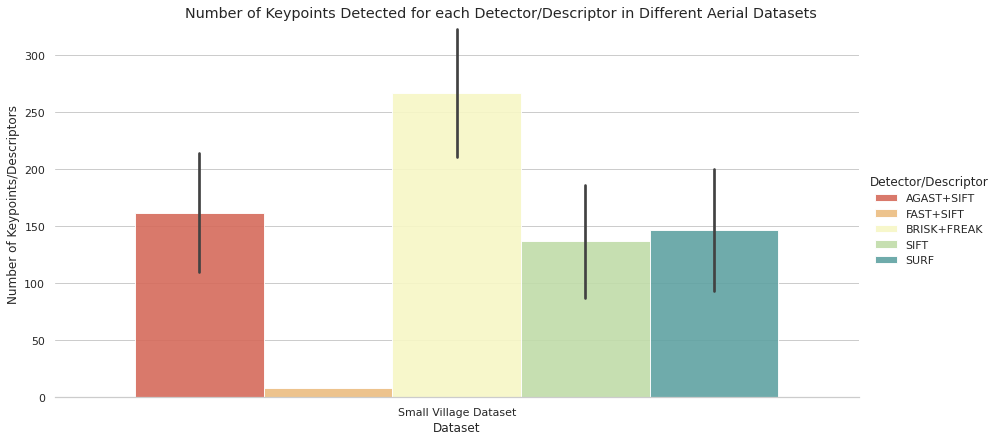

In [61]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_5, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_8_{Dataset}.png')

In [62]:
df_numkey_5.to_csv(f'drive/MyDrive/Num_Kypoints_5_{Dataset}.csv')

In [63]:
print(len(num_matches_agast))

119


Total Number of Matches Detected for each Detector+Descriptor

In [64]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_sift + num_matches_surf + num_matches_freak + num_matches_agast + num_matches_fast, 'Detector/Descriptor': ['AGAST+SIFT']*(len_files-1) + ['SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['FAST+SIFT']*(len_files-1) + ['SURF']*(len_files-1)}
df_match_5 = pd.DataFrame(data=d)
df_match_5['Number of Total Matches'] = df_match_5['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

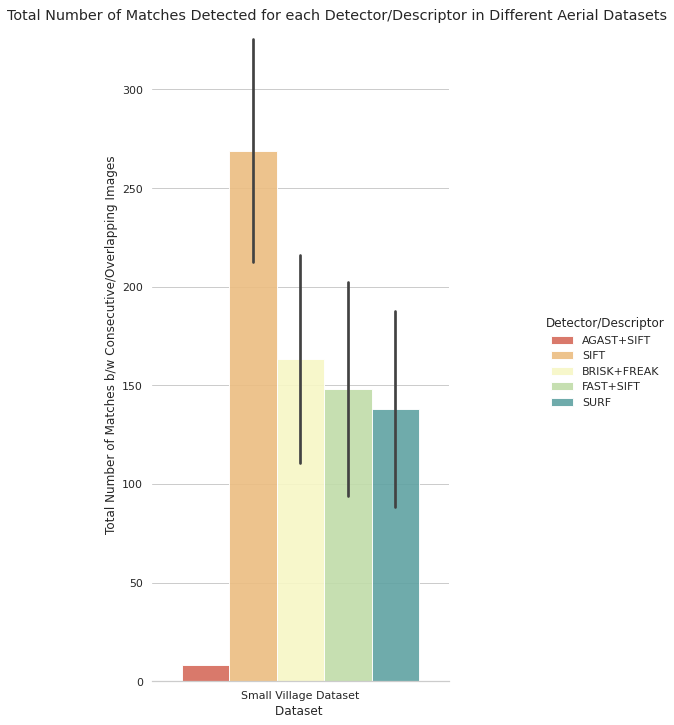

In [65]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_8_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [66]:
df_match_5['Number of Good Matches'] =  num_good_matches_sift + num_good_matches_surf + num_good_matches_freak + num_good_matches_agast + num_good_matches_fast
df_match_5['Number of Good Matches'] = df_match_5['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

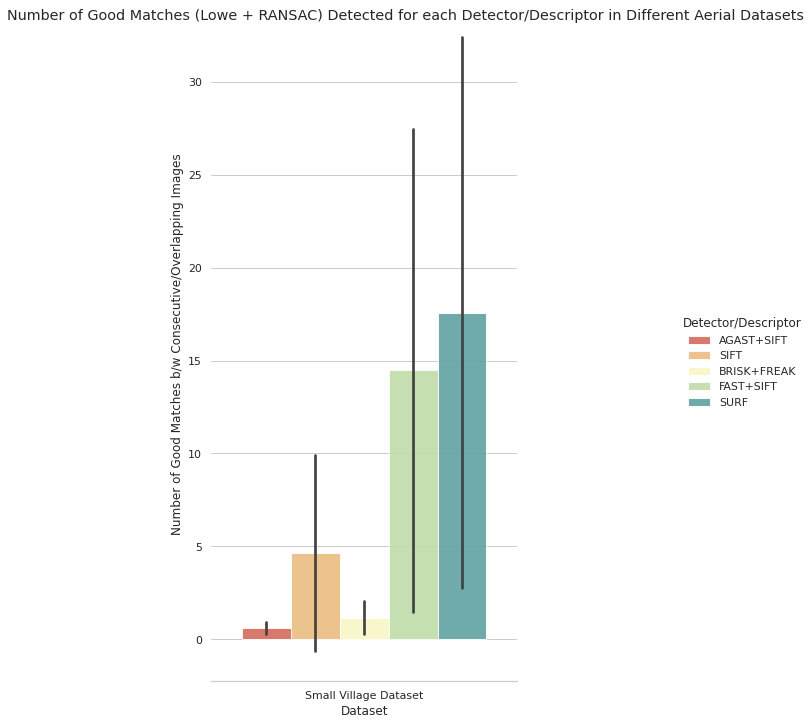

In [67]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_8.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [68]:
df_match_5['Recall Rate of Matches'] = df_match_5['Number of Good Matches']/df_match_5['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

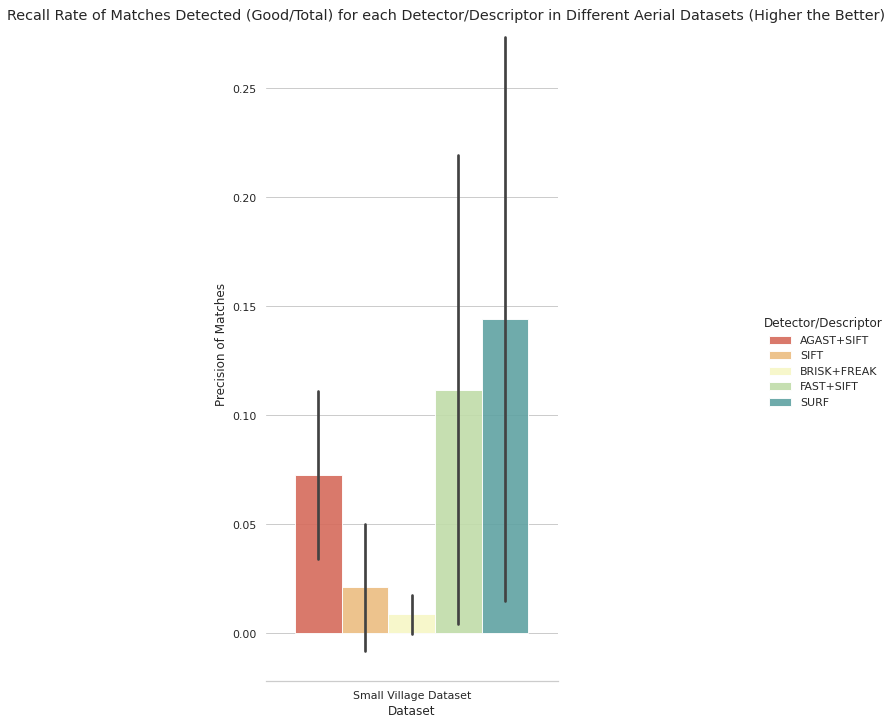

In [69]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_8.png')

1-Precision Rate for each Detector+Descriptor

In [70]:
df_match_5['1 - Precision Rate of Matches'] = (df_match_5['Number of Total Matches'] - df_match_5['Number of Good Matches'])/df_match_5['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

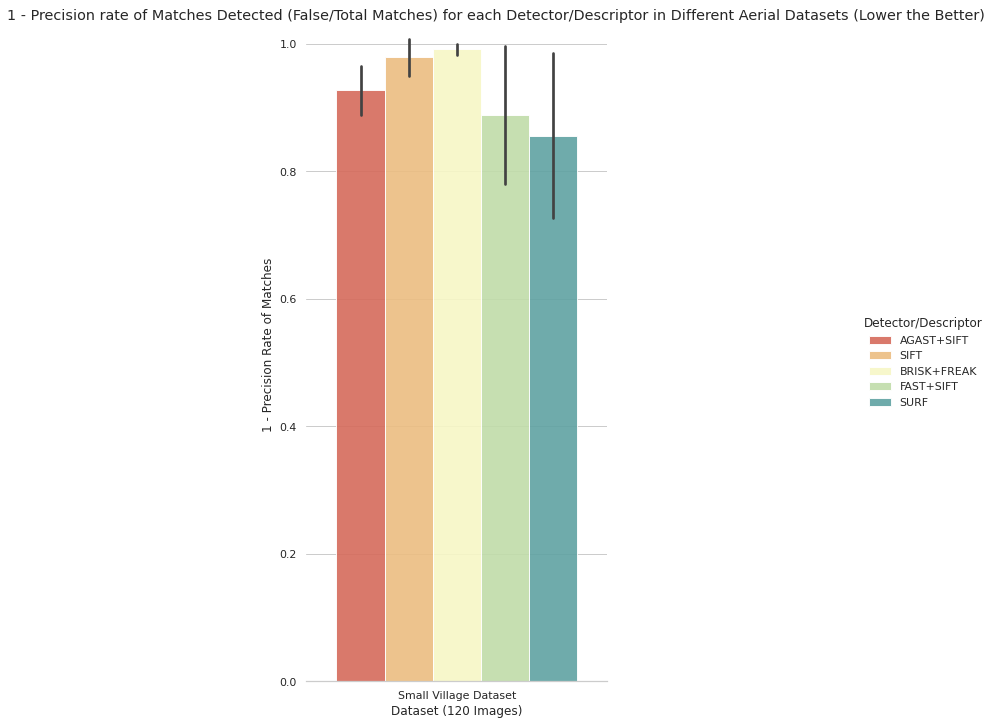

In [72]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5,kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_8.png')

F-Score for each Detector+Descriptor

In [74]:
df_match_5['F-Score'] = (2* (1 - df_match_5['1 - Precision Rate of Matches']) * df_match_5['Recall Rate of Matches'])/((1 - df_match_5['1 - Precision Rate of Matches']) + df_match_5['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

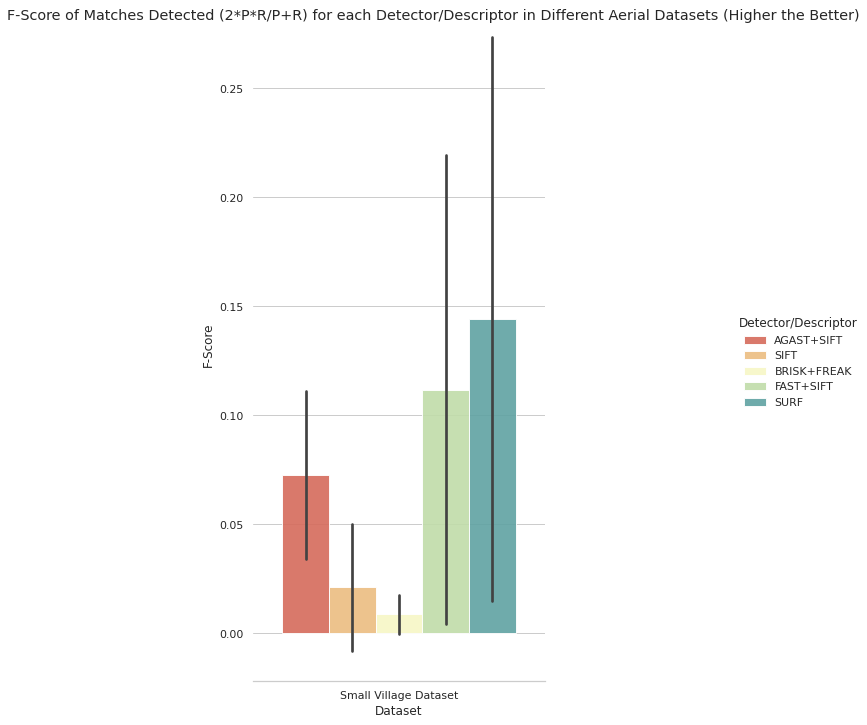

In [75]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_8.png')

In [76]:
df_match_5.to_csv('drive/MyDrive/All_metrics_5.csv')

Time for each Detector+Descriptor

In [77]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[3]] + [time_all[0]] + [time_all[2]] + [time_all[1]] + [time_all[4]], 'Detector/Descriptor': ['AGAST+SIFT'] + ['FAST+SIFT']*(1) + ['BRISK+FREAK']*(1) + ['SURF']*(1) +  ['SIFT']*(1) }
df_time_5 = pd.DataFrame(data=d)

In [78]:
print(df_time_5)

                 Dataset        Time Detector/Descriptor
0  Small Village Dataset  137.789900          AGAST+SIFT
1  Small Village Dataset   69.319830           FAST+SIFT
2  Small Village Dataset  171.139946         BRISK+FREAK
3  Small Village Dataset  187.066598                SURF
4  Small Village Dataset  204.605793                SIFT


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

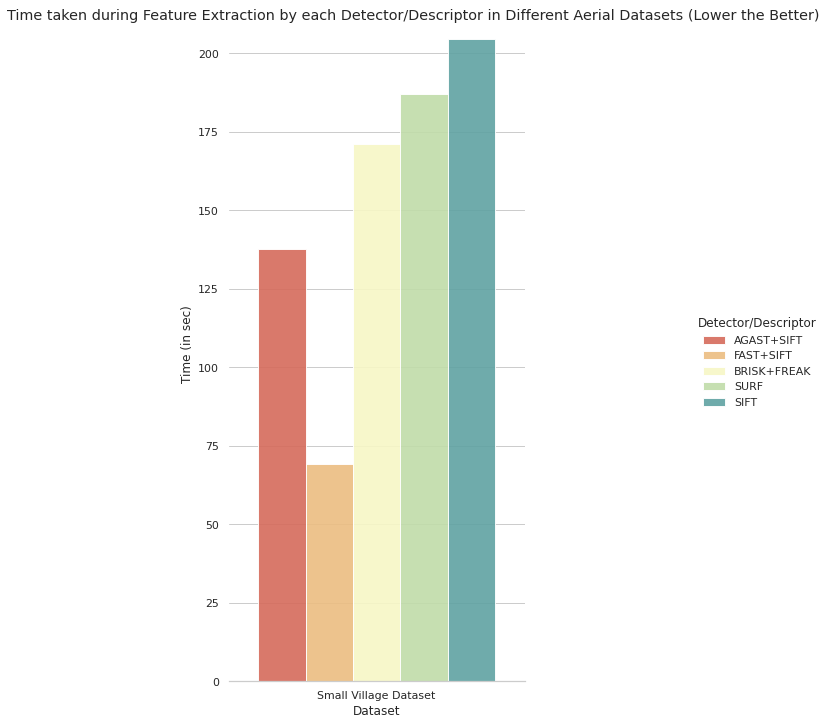

In [79]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_5, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_8.png')

In [80]:
df_time_5.to_csv('drive/MyDrive/Time_5.csv')

Stitching with CPU